## Fungi Image Classification

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob
import cv2
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, cross_validate, ShuffleSplit
from sklearn import preprocessing

import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, DepthwiseConv2D, Activation, Add, MaxPool2D
import keras
#from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam, AdamW
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import Callback
from skimage.metrics import structural_similarity as ssim
import joblib
from sklearn.svm import OneClassSVM

print("Tensorflow Version:", tf.__version__)
print("Keras Version:", keras.__version__)

#project_path = 'Defungi_S'
project_path = 'Defungi'
project_seed = 42
project_image_size = (32,32)
#project_image_size = (64,64)
#project_image_size = (128,128)
#project_image_size = (500,500)
project_filter_size = 256
#project_batch_size = 32
project_batch_size = 128
project_epochs = 4;
project_folds = 2;
project_split = 0.8;
project_learning_rate = 0.0001
project_auto = tf.data.AUTOTUNE


Tensorflow Version: 2.14.0
Keras Version: 2.14.0


In [32]:
def variance_of_Laplacian(image_path, ker_edge_detect):
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    img = cv2.filter2D(src = image_gray.astype("uint8"), ddepth = -1, kernel = ker_edge_detect)
    variance = np.var(img)
    return variance

#    image = cv2.imread(image_path)
#    variance = np.zeros((1,3))
#    for i in range(3):
#        img = cv2.filter2D(src = image[i].astype("uint8"), ddepth = -1, kernel = ker_edge_detect)
#        variance[0,i] = np.var(img)
#    return np.linalg.norm(variance)

In [33]:
def rotate_and_subtract(image_path, ker_edge_detect):
#def variance_of_Laplacian(image_path, ker_edge_detect):
    imageA = cv2.imread(image_path)
    np.reshape(imageA, (-1,1))
    imageB = cv2.rotate(imageA, cv2.ROTATE_90_CLOCKWISE)
    imageC = cv2.rotate(imageB, cv2.ROTATE_90_CLOCKWISE)
    imageD = cv2.rotate(imageC, cv2.ROTATE_90_CLOCKWISE)
#    std_dev = np.std(imageA - imageB + imageC - imageD)
#    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
#    err = err / float(imageA.shape[0] * imageA.shape[1])
    
	# return the MSE, the lower the error, the more "similar"
	# the two images are
#    return std_dev
    image = imageA - imageB + imageC - imageD
    image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    img = cv2.filter2D(src = image_gray.astype("uint8"), ddepth = -1, kernel = ker_edge_detect)
#    variance = np.var(image_gray - img)
    variance = np.var(img)
    return variance

def image_std(image_path):
    image = cv2.imread(image_path)
    np.reshape(image, (-1,1))
    std_dev = np.std(image)

    return std_dev


In [34]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err
    
def compare_images(image_path, ker_edge_detect):
	# compute the mean squared error and structural similarity
	# index for the images
    image  = cv2.imread(image_path)
    imageA = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    imageB = cv2.filter2D(src = imageA.astype("uint8"), ddepth = -1, kernel = ker_edge_detect)
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB)

    vec_arg = np.array([m, s])
    return vec_arg


In [35]:
def image_varience(image_path):
    image  = cv2.imread(image_path)
    mean = np.mean(image)
    variance = np.mean((image - mean) ** 2)
    return variance

### Preprocessing the Data and Organizing as a csv-file

In [151]:
# Load data from the directory using Pandas
# image_data = 'Defungi'

files = [i for i in glob.glob(project_path + "//*//*")]
np.random.shuffle(files)

# Taking the 2 symbols between the string 'Defungi\' and the file-name
labels = [os.path.dirname(i).split("/")[-1][-2:] for i in files]
fungus_classes = {'H1':0, 'H2':1, 'H3':2, 'H5':3, 'H6':4}
classes = [fungus_classes[labels[i]] for i in range(len(labels))]

# Kernels for edge detecting
ker_edge_detect_1 = np.array([[-1, -1, -1], 
                              [-1,  8, -1], 
                              [-1, -1, -1]])
ker_edge_detect_2 = np.array([[ 0, -1,  0], 
                              [-1,  4, -1], 
                              [ 0, -1,  0]])
ker_Sobel_x = np.array([[ -1,  0,  1], 
                        [ -2,  0,  2], 
                        [ -1,  0,  1]])
ker_Sobel_y = np.array([[ -1, -2, -1], 
                        [  0,  0,  0], 
                        [  1,  2,  1]])
ker_Sharpen = np.array([[ 0, -1,  0],
                        [-1,  5, -1],
                        [ 0, -1,  0]])
ker_Blurring = 1/9 *  np.array([[1, 1, 1],
                               [1, 1, 1],
                               [1, 1, 1]])
#STD_Dif = [rotate_and_subtract(i) for i in glob.glob(project_path + "//*//*")]
#print("STD of subtraction is calculated")
#STD     = [image_std(i) for i in glob.glob(project_path + "//*//*")]
#print("STD is calculated")
Edge_1  = [variance_of_Laplacian(i, ker_edge_detect_1) for i in glob.glob(project_path + "//*//*")]
print("Edge_1 is calculated")
Edge_2  = [variance_of_Laplacian(i, ker_edge_detect_2) for i in glob.glob(project_path + "//*//*")]
print("Edge_2 is calculated")

MSE_Sharp = []
SSIM_Sharp = []
MSE_Blur = []
SSIM_Blur = []
for i in glob.glob(project_path + "//*//*"):
    vec = compare_images(i, ker_Sharpen)
    MSE_Sharp.append(vec[0])
    SSIM_Sharp.append(vec[1])

    vec = compare_images(i, ker_Blurring)
    MSE_Blur.append(vec[0])
    SSIM_Blur.append(vec[1])
print("MSE and SSIM are calculated")

Sobel_x = [variance_of_Laplacian(i, ker_Sobel_x) for i in glob.glob(project_path + "//*//*")]
print("Sobel_x is calculated")
Sobel_y = [variance_of_Laplacian(i, ker_Sobel_y) for i in glob.glob(project_path + "//*//*")]
print("Sobel_y is calculated")
Image_varience = [image_varience(i) for i in glob.glob(project_path + "//*//*")]
print("Image_varience is calculated")

data = zip(files, labels, classes, MSE_Sharp/max(MSE_Sharp), SSIM_Sharp,
           MSE_Blur/max(MSE_Blur), SSIM_Blur, Edge_1/max(Edge_1), Edge_2/max(Edge_2),
           Sobel_x/max(Sobel_x), Sobel_y/max(Sobel_y), Image_varience/max(Image_varience))
dataframe = pd.DataFrame(data, columns = ["Image", "Label", "Class", "MSE_Sharp", "SSIM_Sharp",
                                          "MSE_Blur", "SSIM_Blur", "Edge_1", "Edge_2",
                                          "Sobel_x", "Sobel_y", "Image_varience"])

#Class = [fungus_classes[labels(i)] for i in files]

#data = zip(files, labels, classes, edge_1/max(edge_1), edge_2/max(edge_2), Sobel_x/max(Sobel_x), Sobel_y/max(Sobel_y), STD, STD_Dif)
#dataframe = pd.DataFrame(data, columns = ["Image", "Label", "Class", "Edge_1", "Edge_2", "Sobel_x", "Sobel_y", "STD", "STD_dif"])
#data = zip(files, labels, classes, edge_1/max(edge_1), edge_2/max(edge_2), Sobel_x/max(Sobel_x), Sobel_y/max(Sobel_y))
#dataframe = pd.DataFrame(data, columns = ["Image", "Label", "Class", "Edge_1", "Edge_2", "Sobel_x", "Sobel_y"])
dataframe.to_csv(project_path + '\Defungi.csv')
print(dataframe)

Edge_1 is calculated
Edge_2 is calculated
MSE and SSIM are calculated
Sobel_x is calculated
Sobel_y is calculated
Image_varience is calculated
                         Image Label  Class  MSE_Sharp  SSIM_Sharp  MSE_Blur  \
0     Defungi\H1\H1_108b_4.jpg    H1      0   0.082662    0.899381  0.044285   
1      Defungi\H3\H3_13c_1.jpg    H3      2   0.057602    0.913397  0.030640   
2     Defungi\H5\H5_142a_3.jpg    H5      3   0.050740    0.916916  0.026781   
3       Defungi\H1\H1_4c_6.jpg    H1      0   0.074528    0.903972  0.040049   
4      Defungi\H3\H3_16a_1.jpg    H3      2   0.048353    0.918092  0.025852   
...                        ...   ...    ...        ...         ...       ...   
9040   Defungi\H1\H1_69b_3.jpg    H1      0   0.236428    0.905982  0.138343   
9041   Defungi\H2\H2_81b_2.jpg    H2      1   0.169209    0.910191  0.097794   
9042   Defungi\H1\H1_76d_5.jpg    H1      0   0.139408    0.911235  0.079438   
9043   Defungi\H6\H6_16a_4.jpg    H6      4   0.190073   

In [36]:
dataframe = pd.read_csv(project_path + '/Defungi.csv')
dataframe['Sobel'] = np.sqrt(np.square(dataframe['Sobel_x']) + np.square(dataframe['Sobel_y']))
print(dataframe)
dataframe.to_csv(project_path + '\Defungi.csv')

      Unnamed: 0.1  Unnamed: 0                     Image Label  Class  \
0                0           0  Defungi\H1\H1_100a_1.jpg    H1      0   
1                1           1  Defungi\H1\H1_100a_2.jpg    H1      0   
2                2           2  Defungi\H1\H1_100a_3.jpg    H1      0   
3                3           3  Defungi\H1\H1_100a_4.jpg    H1      0   
4                4           4  Defungi\H1\H1_100a_5.jpg    H1      0   
...            ...         ...                       ...   ...    ...   
9040          9040        9040    Defungi\H6\H6_9a_2.jpg    H6      4   
9041          9041        9041    Defungi\H6\H6_9a_3.jpg    H6      4   
9042          9042        9042    Defungi\H6\H6_9a_4.jpg    H6      4   
9043          9043        9043    Defungi\H6\H6_9a_5.jpg    H6      4   
9044          9044        9044    Defungi\H6\H6_9a_6.jpg    H6      4   

        Variance     Sobel_x     Sobel_y  Norm_Variance  Norm_Sobel_x  \
0     247.598146   59.766566   57.663307       0.0

In [37]:
dataframe = pd.read_csv(project_path + '/Defungi.csv')
# Train an SVM classifier on the dataset
svm = OneClassSVM(kernel = 'rbf', gamma = 'scale', nu = 0.02)
#svm = OneClassSVM(kernel = 'rbf', gamma = 0.0001, nu = 0.03)
df = dataframe.filter(['MSE_Blur', 'Edge_1', 'Edge_2', 'Sobel', 'Image_varience'])
svm.fit(df)

# Predict the scores and labels of the data points
scores = svm.score_samples(df)
labels = svm.predict(df)

# Add the scores and labels as columns to the dataframe
df['score'] = scores
df['label'] = labels

# Filter the outliers based on the label column
outliers = df[df['label'] == -1]

# Print the outliers
print(outliers)


           Sobel      score  label
1163  477.505358  32.296464     -1
1164  476.595528  32.296443     -1
1165  475.518260  32.296421     -1
1166  473.565371  32.296390     -1
3182    7.560606  32.192266     -1
...          ...        ...    ...
8859    7.744454  32.205995     -1
8860    7.653617  32.199219     -1
8864    7.988351  32.224111     -1
9040  709.940721  32.296136     -1
9041  460.084262  32.296504     -1

[168 rows x 3 columns]


In [38]:
#df = pd.merge(dataframe, outliers, left_index = True, right_index = True)
df = pd.concat([dataframe.iloc[:,0:4], outliers], axis = 1, join = 'inner')
#print(df)
#print(df['score'].values)
Quantile = df[['score']].quantile(0.5)
print(Quantile)
#df = df.loc[(df['score'] > Quantile['score'])]
df = df.sort_values(by = 'score', ascending = True)
df = df.reset_index(drop = True)
print(df)

score    32.262627
Name: 0.5, dtype: float64
     Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0                     Image  \
0            8503          8503        8503   Defungi\H6\H6_31a_3.jpg   
1            8502          8502        8502   Defungi\H6\H6_31a_2.jpg   
2            8501          8501        8501   Defungi\H6\H6_31a_1.jpg   
3            8215          8215        8215   Defungi\H5\H5_81a_2.jpg   
4            7914          7914        7914   Defungi\H5\H5_27a_2.jpg   
..            ...           ...         ...                       ...   
163          7947          7947        7947   Defungi\H5\H5_35a_1.jpg   
164          6847          6847        6847   Defungi\H3\H3_14b_3.jpg   
165          7524          7524        7524  Defungi\H5\H5_108a_4.jpg   
166          8421          8421        8421   Defungi\H6\H6_24a_6.jpg   
167          8245          8245        8245   Defungi\H5\H5_88b_4.jpg   

           Sobel      score  label  
0    1855.806347   1.030375     -1  
1   

In [39]:
for k in range(70, 90):
    print(df.loc[k, 'Image'])
    # Read the image file
    image = cv2.imread(df.loc[k, 'Image'])
    
    # Show the image in a window named 'Outlier Image'
    cv2.imshow('Outlier Image', image)
    
    # Wait for a key press to close the window
    cv2.waitKey(0)

    # Destroy all windows
    cv2.destroyAllWindows()

Defungi\H1\H1_73a_2.jpg
Defungi\H1\H1_73a_6.jpg
Defungi\H6\H6_63a_9.jpg
Defungi\H5\H5_112b_3.jpg
Defungi\H6\H6_4a_4.jpg
Defungi\H5\H5_53a_3.jpg
Defungi\H2\H2_93a_9.jpg
Defungi\H2\H2_93a_1.jpg
Defungi\H6\H6_63a_10.jpg
Defungi\H1\H1_73a_5.jpg
Defungi\H1\H1_73b_1.jpg
Defungi\H1\H1_73a_3.jpg
Defungi\H1\H1_73a_4.jpg
Defungi\H1\H1_73a_17.jpg
Defungi\H1\H1_73a_12.jpg
Defungi\H2\H2_25a_14.jpg
Defungi\H1\H1_73a_7.jpg
Defungi\H5\H5_68a_4.jpg
Defungi\H6\H6_63a_3.jpg
Defungi\H1\H1_73a_22.jpg


### Exploring the Data

In [40]:
# Load training and testing data from the xray_data dataset using Pandas
Defungi_data = pd.read_csv(project_path + '\Defungi.csv')
Defungi_data.info()
print(Defungi_data.head(4))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9045 entries, 0 to 9044
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0.2   9045 non-null   int64  
 1   Unnamed: 0.1   9045 non-null   int64  
 2   Unnamed: 0     9045 non-null   int64  
 3   Image          9045 non-null   object 
 4   Label          9045 non-null   object 
 5   Class          9045 non-null   int64  
 6   Variance       9045 non-null   float64
 7   Sobel_x        9045 non-null   float64
 8   Sobel_y        9045 non-null   float64
 9   Norm_Variance  9045 non-null   float64
 10  Norm_Sobel_x   9045 non-null   float64
 11  Norm_Sobel_y   9045 non-null   float64
 12  Sobel          9045 non-null   float64
dtypes: float64(7), int64(4), object(2)
memory usage: 918.8+ KB
   Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0                     Image Label  \
0             0             0           0  Defungi\H1\H1_100a_1.jpg    H1   
1             1

In [41]:
Defungi_data.describe()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Class,Variance,Sobel_x,Sobel_y,Norm_Variance,Norm_Sobel_x,Norm_Sobel_y,Sobel
count,9045.000000,9045.000000,9045.000000,9045.000000,9045.000000,9045.000000,9045.000000,9045.000000,9045.000000,9045.000000,9045.000000
mean,4522.000000,4522.000000,4522.000000,1.029630,320.064073,57.933301,58.095566,0.060915,0.048987,0.040621,82.590489
std,2611.210926,2611.210926,2611.210926,1.293763,432.585947,100.968144,98.309531,0.082331,0.085376,0.068740,140.604030
min,0.000000,0.000000,0.000000,0.000000,4.250393,4.260925,3.189513,0.000809,0.003603,0.002230,5.742274
25%,2261.000000,2261.000000,2261.000000,0.000000,93.871397,17.458706,17.800235,0.017866,0.014763,0.012446,25.115669
50%,4522.000000,4522.000000,4522.000000,1.000000,184.037203,27.680398,27.728023,0.035026,0.023406,0.019388,39.579725
75%,6783.000000,6783.000000,6783.000000,2.000000,334.321554,49.867541,49.200007,0.063629,0.042166,0.034401,70.834704
max,9044.000000,9044.000000,9044.000000,4.000000,5254.258609,1182.635200,1430.171732,1.000000,1.000000,1.000000,1855.806347


### Uploading the Images from the Directory
#### A small version of Dataset can be uploaded for testing models and algorithms

In [42]:
import pathlib

data_dir = pathlib.Path(project_path)

data_train, data_test = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    subset = 'both',
    labels = 'inferred',
#    label_mode = 'int',
    color_mode = 'rgb',
    image_size = project_image_size,
    batch_size = project_batch_size,
    seed = project_seed,
    validation_split = 0.3)

for x, y in data_test.take(4):
    print(x.shape, y)


Found 9045 files belonging to 5 classes.
Using 6332 files for training.
Using 2713 files for validation.
(128, 32, 32, 3) tf.Tensor(
[3 0 0 0 0 0 4 4 2 0 0 1 0 2 1 0 0 1 2 0 0 0 0 1 4 0 0 0 1 1 2 1 0 0 1 1 0
 0 0 0 3 0 4 0 1 0 0 0 1 0 4 3 4 0 0 0 0 3 4 4 3 4 0 0 0 0 1 3 4 0 2 1 0 0
 2 0 2 0 0 0 2 2 0 1 0 2 4 2 1 0 4 1 3 1 4 1 3 1 0 1 1 0 4 1 3 0 0 4 4 2 4
 0 0 1 0 1 0 1 4 3 1 0 1 1 1 1 0 3], shape=(128,), dtype=int32)
(128, 32, 32, 3) tf.Tensor(
[1 0 0 0 2 1 0 0 1 0 0 1 0 3 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 2 0 1 0
 4 1 0 1 0 4 4 1 0 1 4 0 2 2 0 0 0 2 1 0 2 0 1 0 0 0 0 0 0 3 1 2 3 2 0 0 1
 0 0 0 2 1 0 1 1 0 1 3 0 3 4 2 2 1 3 3 1 0 3 1 3 2 2 0 0 4 1 0 0 0 0 1 0 0
 0 0 4 4 0 1 1 2 0 0 0 1 4 0 0 4 1], shape=(128,), dtype=int32)
(128, 32, 32, 3) tf.Tensor(
[1 0 1 1 0 2 0 3 1 1 0 0 0 0 2 0 0 4 3 0 1 1 0 3 4 4 4 0 1 4 2 4 1 1 3 4 0
 2 4 1 4 0 0 0 0 0 0 4 1 2 2 0 4 1 0 1 0 2 0 4 0 0 0 0 0 0 2 0 4 3 0 2 0 0
 4 0 0 1 3 2 0 0 4 0 3 0 0 3 1 3 1 0 1 1 1 1 0 1 0 1 0 0 0 2 0 3 2 0 1 1 0
 0 0 0 0

### Image Preprocessing: Excluding Blurred Images

In [43]:
Defungi_data = pd.read_csv(project_path + '/Defungi.csv')
Defungi_data_clear = Defungi_data[~Defungi_data['Image'].isin(df['Image'])]
print(Defungi_data_clear.describe())
Defungi_data_blurred = Defungi_data[Defungi_data['Image'].isin(df['Image'])]
print(Defungi_data_blurred.describe())

       Unnamed: 0.2  Unnamed: 0.1   Unnamed: 0        Class     Variance  \
count   8877.000000   8877.000000  8877.000000  8877.000000  8877.000000   
mean    4466.235891   4466.235891  4466.235891     0.995494   308.048182   
std     2593.739833   2593.739833  2593.739833     1.272115   415.658270   
min        0.000000      0.000000     0.000000     0.000000     4.250393   
25%     2223.000000   2223.000000  2223.000000     0.000000    92.858020   
50%     4454.000000   4454.000000  4454.000000     1.000000   181.336522   
75%     6678.000000   6678.000000  6678.000000     2.000000   322.613989   
max     9044.000000   9044.000000  9044.000000     4.000000  5254.258609   

           Sobel_x      Sobel_y  Norm_Variance  Norm_Sobel_x  Norm_Sobel_y  \
count  8877.000000  8877.000000    8877.000000   8877.000000   8877.000000   
mean     49.922782    50.396654       0.058628      0.042213      0.035238   
std      71.883233    71.014628       0.079109      0.060782      0.049655   
min

In [44]:
Defungi_data = pd.read_csv(project_path + '/Defungi.csv')
#Quantile = Defungi_data[['Edge_1','Sobel_x','Sobel_y','STD','STD_Dif']].quantile(0.03)
#Quantile = Defungi_data[['Edge_1','Sobel_x','Sobel_y']].quantile(0.05)
#Quantile = Defungi_data[['Sobel_x','Sobel_y','MSE','SSIM', 'Image_varience']].quantile(0.05)
Quantile = Defungi_data[['Sobel_x','Sobel_y','MSE_Sharp','MSE_Blur', 'Image_varience']].quantile(0.05)
#Quantile = Defungi_data[['Error']].quantile(0.01)

# Drop the blurred datapoints (edges are not clear according to three types of algorithms
# (a simple kernel 8 surrounded by negative ones and two Sobel edges) 

#Defungi_data_clear = Defungi_data.loc[(Defungi_data['Edge_1'] > Quantile['Edge_1'])
#Defungi_data_clear = Defungi_data.loc[(Defungi_data['Sobel_x'] > Quantile['Sobel_x'])
#                                    | (Defungi_data['Sobel_y'] > Quantile['Sobel_y'])
#                                    | (Defungi_data['Image_varience'] > Quantile['Image_varience'])
#                                    | (Defungi_data['MSE'] > Quantile['MSE'])
#                                    | (Defungi_data['SSIM'] > Quantile['SSIM'])]
#                                    | (Defungi_data['STD_Dif'] > Quantile['STD_Dif'])]
#                                    | (Defungi_data['STD'] > Quantile['STD'])]
Defungi_data_clear = Defungi_data.loc[
#(Defungi_data['Image_varience'] > Quantile['Image_varience'])
                                      (Defungi_data['Sobel_x'] > Quantile['Sobel_x'])
                                    | (Defungi_data['Sobel_y'] > Quantile['Sobel_y'])
#                                    | (Defungi_data['MSE_Sharp'] > Quantile['MSE_Sharp'])
                                    | (Defungi_data['MSE_Blur'] > Quantile['MSE_Blur'])]
#Defungi_data_blurred = Defungi_data.loc[(Defungi_data['Edge_1'] < Quantile['Edge_1'])
#Defungi_data_blurred = Defungi_data.loc[(Defungi_data['Sobel_x'] < Quantile['Sobel_x'])
#                                    & (Defungi_data['Sobel_y'] < Quantile['Sobel_y'])
#                                    & (Defungi_data['Image_varience'] < Quantile['Image_varience'])
#                                    & (Defungi_data['MSE'] < Quantile['MSE'])
#                                    & (Defungi_data['SSIM'] < Quantile['SSIM'])]
Defungi_data_blurred = Defungi_data.loc[
#(Defungi_data['Image_varience'] < Quantile['Image_varience'])
                                      (Defungi_data['Sobel_x'] < Quantile['Sobel_x'])
                                    & (Defungi_data['Sobel_y'] < Quantile['Sobel_y'])
#                                    & (Defungi_data['MSE_Sharp'] < Quantile['MSE_Sharp'])
                                    & (Defungi_data['MSE_Blur'] < Quantile['MSE_Blur'])]
#                                    & (Defungi_data['STD_Dif'] < Quantile['STD_Dif'])]
#                                    & (Defungi_data['STD'] < Quantile['STD'])]
#Defungi_data_clear = Defungi_data.loc[(Defungi_data['STD_Dif'] > Quantile['STD_Dif'])
#                                    | (Defungi_data['STD'] > Quantile['STD'])]
#Defungi_data_blurred = Defungi_data.loc[(Defungi_data['STD_Dif'] < Quantile['STD_Dif'])
#                                    & (Defungi_data['STD'] < Quantile['STD'])]
#Defungi_data_clear = Defungi_data.loc[(Defungi_data['STD_Dif'] > Quantile['STD_Dif'])]
#Defungi_data_blurred = Defungi_data.loc[(Defungi_data['STD_Dif'] < Quantile['STD_Dif'])]

#Defungi_data_clear.reset_index(drop = True, inplace = True)
#Defungi_data_clear.reset_index()
print(Defungi_data_clear.describe())
print(Defungi_data_blurred.describe())
print(Defungi_data_blurred)

#Image_Array = []
#Class_Array = []
#for i in Defungi_data_clear.index:
#    Image_Path = Defungi_data_clear.loc[i, "Image"]
#    Class = Defungi_data_clear.loc[i, "Class"]
#    Class_Array.append(Class)
#    Image = keras.utils.load_img(Image_Path, target_size = project_image_size)
#    Image_Array.append(np.array([Image]))
Defungi_data_blurred.to_csv(project_path + '\Defungi_blurred.csv')

KeyError: "['MSE_Sharp', 'MSE_Blur', 'Image_varience'] not in index"

### Uploading the Images from the Directory
#### A small version of Dataset can be uploaded for testing models and algorithms

In [45]:
# Group the dataframe by class
Defungi_data_split = Defungi_data_clear.groupby(['Class'])

# Get the groups dictionary
groups = Defungi_data_split.groups

# Initialize the Test_data column with 0
Defungi_data_clear.loc[:,'Test_data'] = 0

# Loop over the classes
for Class in groups:
    # Get a random sample of the rows for each class
    sample = Defungi_data_clear.loc[groups[Class]].sample(frac = project_split)
    # Print the number of rows in the sample
    print(len(sample))
    # Assign 1 to the Test_data column for the sample rows
    Defungi_data_clear.loc[sample.index, 'Test_data'] = 1

print(Defungi_data_clear.groupby(['Test_data']).count())

3510
1808
644
583
556
           Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  Image  Label  Class  \
Test_data                                                                
0                  1776          1776        1776   1776   1776   1776   
1                  7101          7101        7101   7101   7101   7101   

           Variance  Sobel_x  Sobel_y  Norm_Variance  Norm_Sobel_x  \
Test_data                                                            
0              1776     1776     1776           1776          1776   
1              7101     7101     7101           7101          7101   

           Norm_Sobel_y  Sobel  
Test_data                       
0                  1776   1776  
1                  7101   7101  


In [46]:

# Define a function to load and preprocess an image
def load_image(image_path, label):
  # Read the image file
    print(image_path)
    image = tf.io.read_file(image_path)
    # Decode the image as JPEG
    image = tf.image.decode_jpeg(image)
    # Resize the image to project_image_size
    image = tf.image.resize(image, np.array(project_image_size))
    # Convert the image to float32 and normalize it
    image = tf.cast(image, tf.float32)
    # Return the image and the label
    return image, label

# Create a TensorFlow dataset from the image and class lists
data_train = tf.data.Dataset.from_tensor_slices((Defungi_data_clear.loc[Defungi_data_clear['Test_data'] == 0, 'Image'],
                                                 Defungi_data_clear.loc[Defungi_data_clear['Test_data'] == 0, 'Class']))

# Apply the load_image function to each element of the dataset using map
data_train = data_train.map(load_image, num_parallel_calls = tf.data.AUTOTUNE)
print(data_train)

data_test = tf.data.Dataset.from_tensor_slices((Defungi_data_clear.loc[Defungi_data_clear['Test_data'] == 1, 'Image'],
                                                Defungi_data_clear.loc[Defungi_data_clear['Test_data'] == 1, 'Class']))

# Apply the load_image function to each element of the dataset using map
data_test = data_test.map(load_image, num_parallel_calls = tf.data.AUTOTUNE)
print(data_test)

# Create batches from the datasets
data_train = data_train.batch(project_batch_size)
data_test = data_test.batch(project_batch_size)

# Prefetching samples in GPU memory helps maximize GPU utilization.
data_train = data_train.prefetch(tf.data.AUTOTUNE)
data_test = data_test.prefetch(tf.data.AUTOTUNE)

# Print the shape of the first batch of the dataset
for image_batch, label_batch in data_train.take(15):
    print(image_batch.shape, label_batch)


Tensor("args_0:0", shape=(), dtype=string)
<_ParallelMapDataset element_spec=(TensorSpec(shape=(32, 32, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Tensor("args_0:0", shape=(), dtype=string)
<_ParallelMapDataset element_spec=(TensorSpec(shape=(32, 32, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
(128, 32, 32, 3) tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(128,), dtype=int64)
(128, 32, 32, 3) tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(128,

In [12]:
# Create a TensorFlow dataset from the image and class lists
data_blurred = tf.data.Dataset.from_tensor_slices((Defungi_data_blurred[:]['Image'],
                                                   Defungi_data_blurred[:]['Class']))

# Apply the load_image function to each element of the dataset using map
data_blurred = data_blurred.map(load_image, num_parallel_calls = tf.data.AUTOTUNE)
#print(data_blurred)
for image_batch, label_batch in data_blurred.take(15):
    print(image_batch.shape, label_batch)

Tensor("args_0:0", shape=(), dtype=string)
(32, 32, 3) tf.Tensor(0, shape=(), dtype=int64)
(32, 32, 3) tf.Tensor(0, shape=(), dtype=int64)
(32, 32, 3) tf.Tensor(0, shape=(), dtype=int64)
(32, 32, 3) tf.Tensor(0, shape=(), dtype=int64)
(32, 32, 3) tf.Tensor(0, shape=(), dtype=int64)
(32, 32, 3) tf.Tensor(0, shape=(), dtype=int64)
(32, 32, 3) tf.Tensor(0, shape=(), dtype=int64)
(32, 32, 3) tf.Tensor(0, shape=(), dtype=int64)
(32, 32, 3) tf.Tensor(0, shape=(), dtype=int64)
(32, 32, 3) tf.Tensor(0, shape=(), dtype=int64)
(32, 32, 3) tf.Tensor(0, shape=(), dtype=int64)
(32, 32, 3) tf.Tensor(0, shape=(), dtype=int64)
(32, 32, 3) tf.Tensor(0, shape=(), dtype=int64)
(32, 32, 3) tf.Tensor(0, shape=(), dtype=int64)
(32, 32, 3) tf.Tensor(0, shape=(), dtype=int64)


In [13]:
Image_List = Defungi_data_clear['Image']
Class_List = Defungi_data_clear['Class']

# Define a function to load and preprocess an image
def load_image(image_path, label):
  # Read the image file
    image = tf.io.read_file(image_path)
    # Decode the image as JPEG
    image = tf.image.decode_jpeg(image)
    # Resize the image to project_image_size
    image = tf.image.resize(image, np.array(project_image_size))
    # Convert the image to float32 and normalize it
    image = tf.cast(image, tf.float32)
    # Return the image and the label
    return image, label

# Create a TensorFlow dataset from the image and class lists
tf_data = tf.data.Dataset.from_tensor_slices((Image_List, Class_List))

# Apply the load_image function to each element of the dataset using map
tf_data = tf_data.map(load_image, num_parallel_calls = tf.data.AUTOTUNE)
print(tf_data)

# Splitting the dataset
total_size = len(tf_data)
# Calculate the number of examples for the test set
test_size = int(total_size * 0.2)
# Split the dataset into train and test sets
data_train = tf_data.skip(test_size)
data_test = tf_data.take(test_size)

# Create batches from the datasets
data_train = data_train.batch(project_batch_size)
data_test = data_test.batch(project_batch_size)

# Prefetching samples in GPU memory helps maximize GPU utilization.
data_train = data_train.prefetch(tf.data.AUTOTUNE)
data_test = data_test.prefetch(tf.data.AUTOTUNE)

# Print the shape of the first batch of the dataset
for image_batch, label_batch in data_train.take(15):
    print(image_batch.shape, label_batch)


<_ParallelMapDataset element_spec=(TensorSpec(shape=(32, 32, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
(128, 32, 32, 3) tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(128,), dtype=int64)
(128, 32, 32, 3) tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(128,), dtype=int64)
(128, 32, 32, 3) tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [14]:
Image_List = Defungi_data_blurred['Image']
Class_List = Defungi_data_blurred['Class']

# Define a function to load and preprocess an image
def load_image(image_path, label):
  # Read the image file
    image = tf.io.read_file(image_path)
    # Decode the image as JPEG
    image = tf.image.decode_jpeg(image)
    # Resize the image to project_image_size
    image = tf.image.resize(image, np.array(project_image_size))
    # Convert the image to float32 and normalize it
    image = tf.cast(image, tf.float32)
    # Return the image and the label
    return image, label

# Create a TensorFlow dataset from the image and class lists
tf_data_blurred = tf.data.Dataset.from_tensor_slices((Image_List, Class_List))

# Apply the load_image function to each element of the dataset using map
tf_data_blurred = tf_data_blurred.map(load_image, num_parallel_calls = tf.data.AUTOTUNE)
print(tf_data_blurred)

# Create batches from the datasets
tf_data_blurred = tf_data_blurred.batch(project_batch_size)

# Prefetching samples in GPU memory helps maximize GPU utilization.
tf_data_blurred = tf_data_blurred.prefetch(tf.data.AUTOTUNE)

# Print the shape of the first batch of the dataset
for image_batch, label_batch in tf_data_blurred.take(15):
    print(image_batch.shape, label_batch)


<_ParallelMapDataset element_spec=(TensorSpec(shape=(32, 32, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
(128, 32, 32, 3) tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4], shape=(128,), dtype=int64)
(40, 32, 32, 3) tf.Tensor(
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4], shape=(40,), dtype=int64)


### Displaying the Images

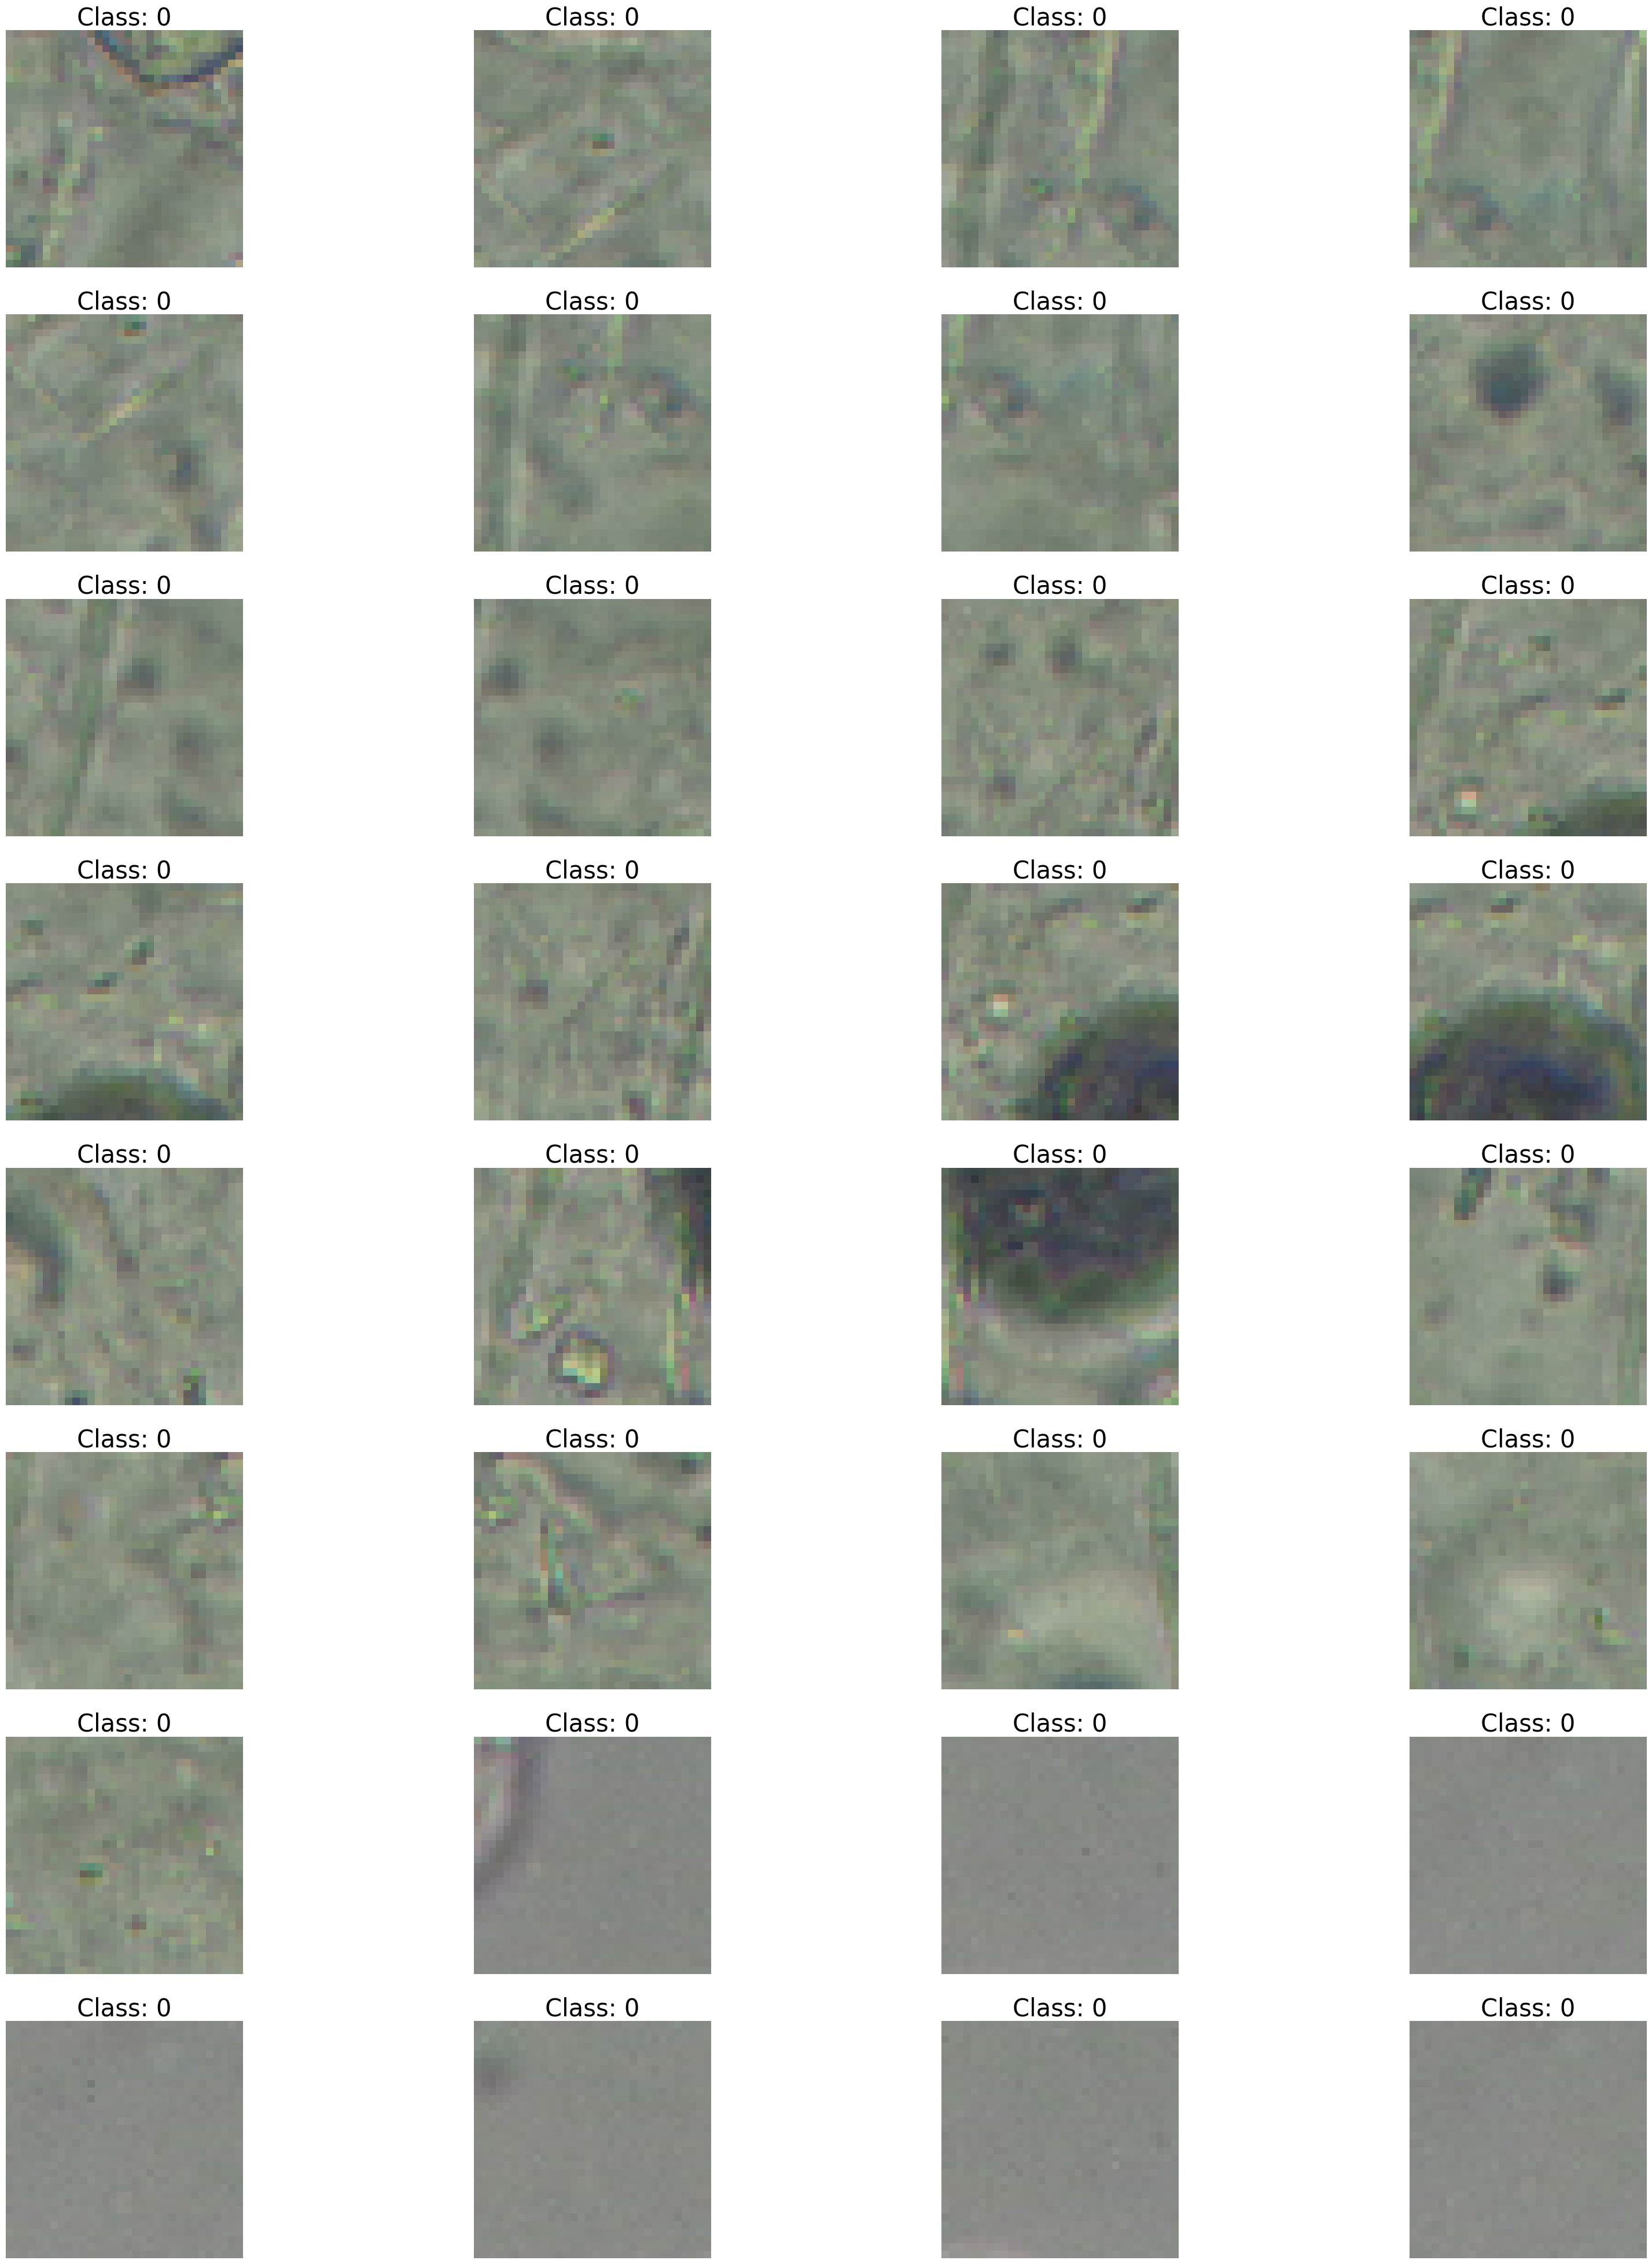

In [15]:
# Display the images
def display_images(df_display):
    data_iterator = df_display.as_numpy_iterator()
    images, labels = data_iterator.next()
    #print(len(images))
    #plt.figure(figsize = (12, 8))
    plt.figure(figsize = (40,50))
    if (len(images) > 32):
        range_for = range(32)
        row_n = 8
    else:
        range_for = range(len(images))
        row_n = round(len(images)/4)
        print(len(images))
        print(row_n)
    for i in range_for:
        plt.subplot(row_n, 4, i + 1)
        plt.imshow(images[i].astype("uint8"))
    #    plt.title(f'Class: {np.argmax(labels[i])}')
        plt.title(f'Class: {labels[i]}', fontsize = 30) 
        plt.axis('off')
    
    plt.show()

display_images(data_train)

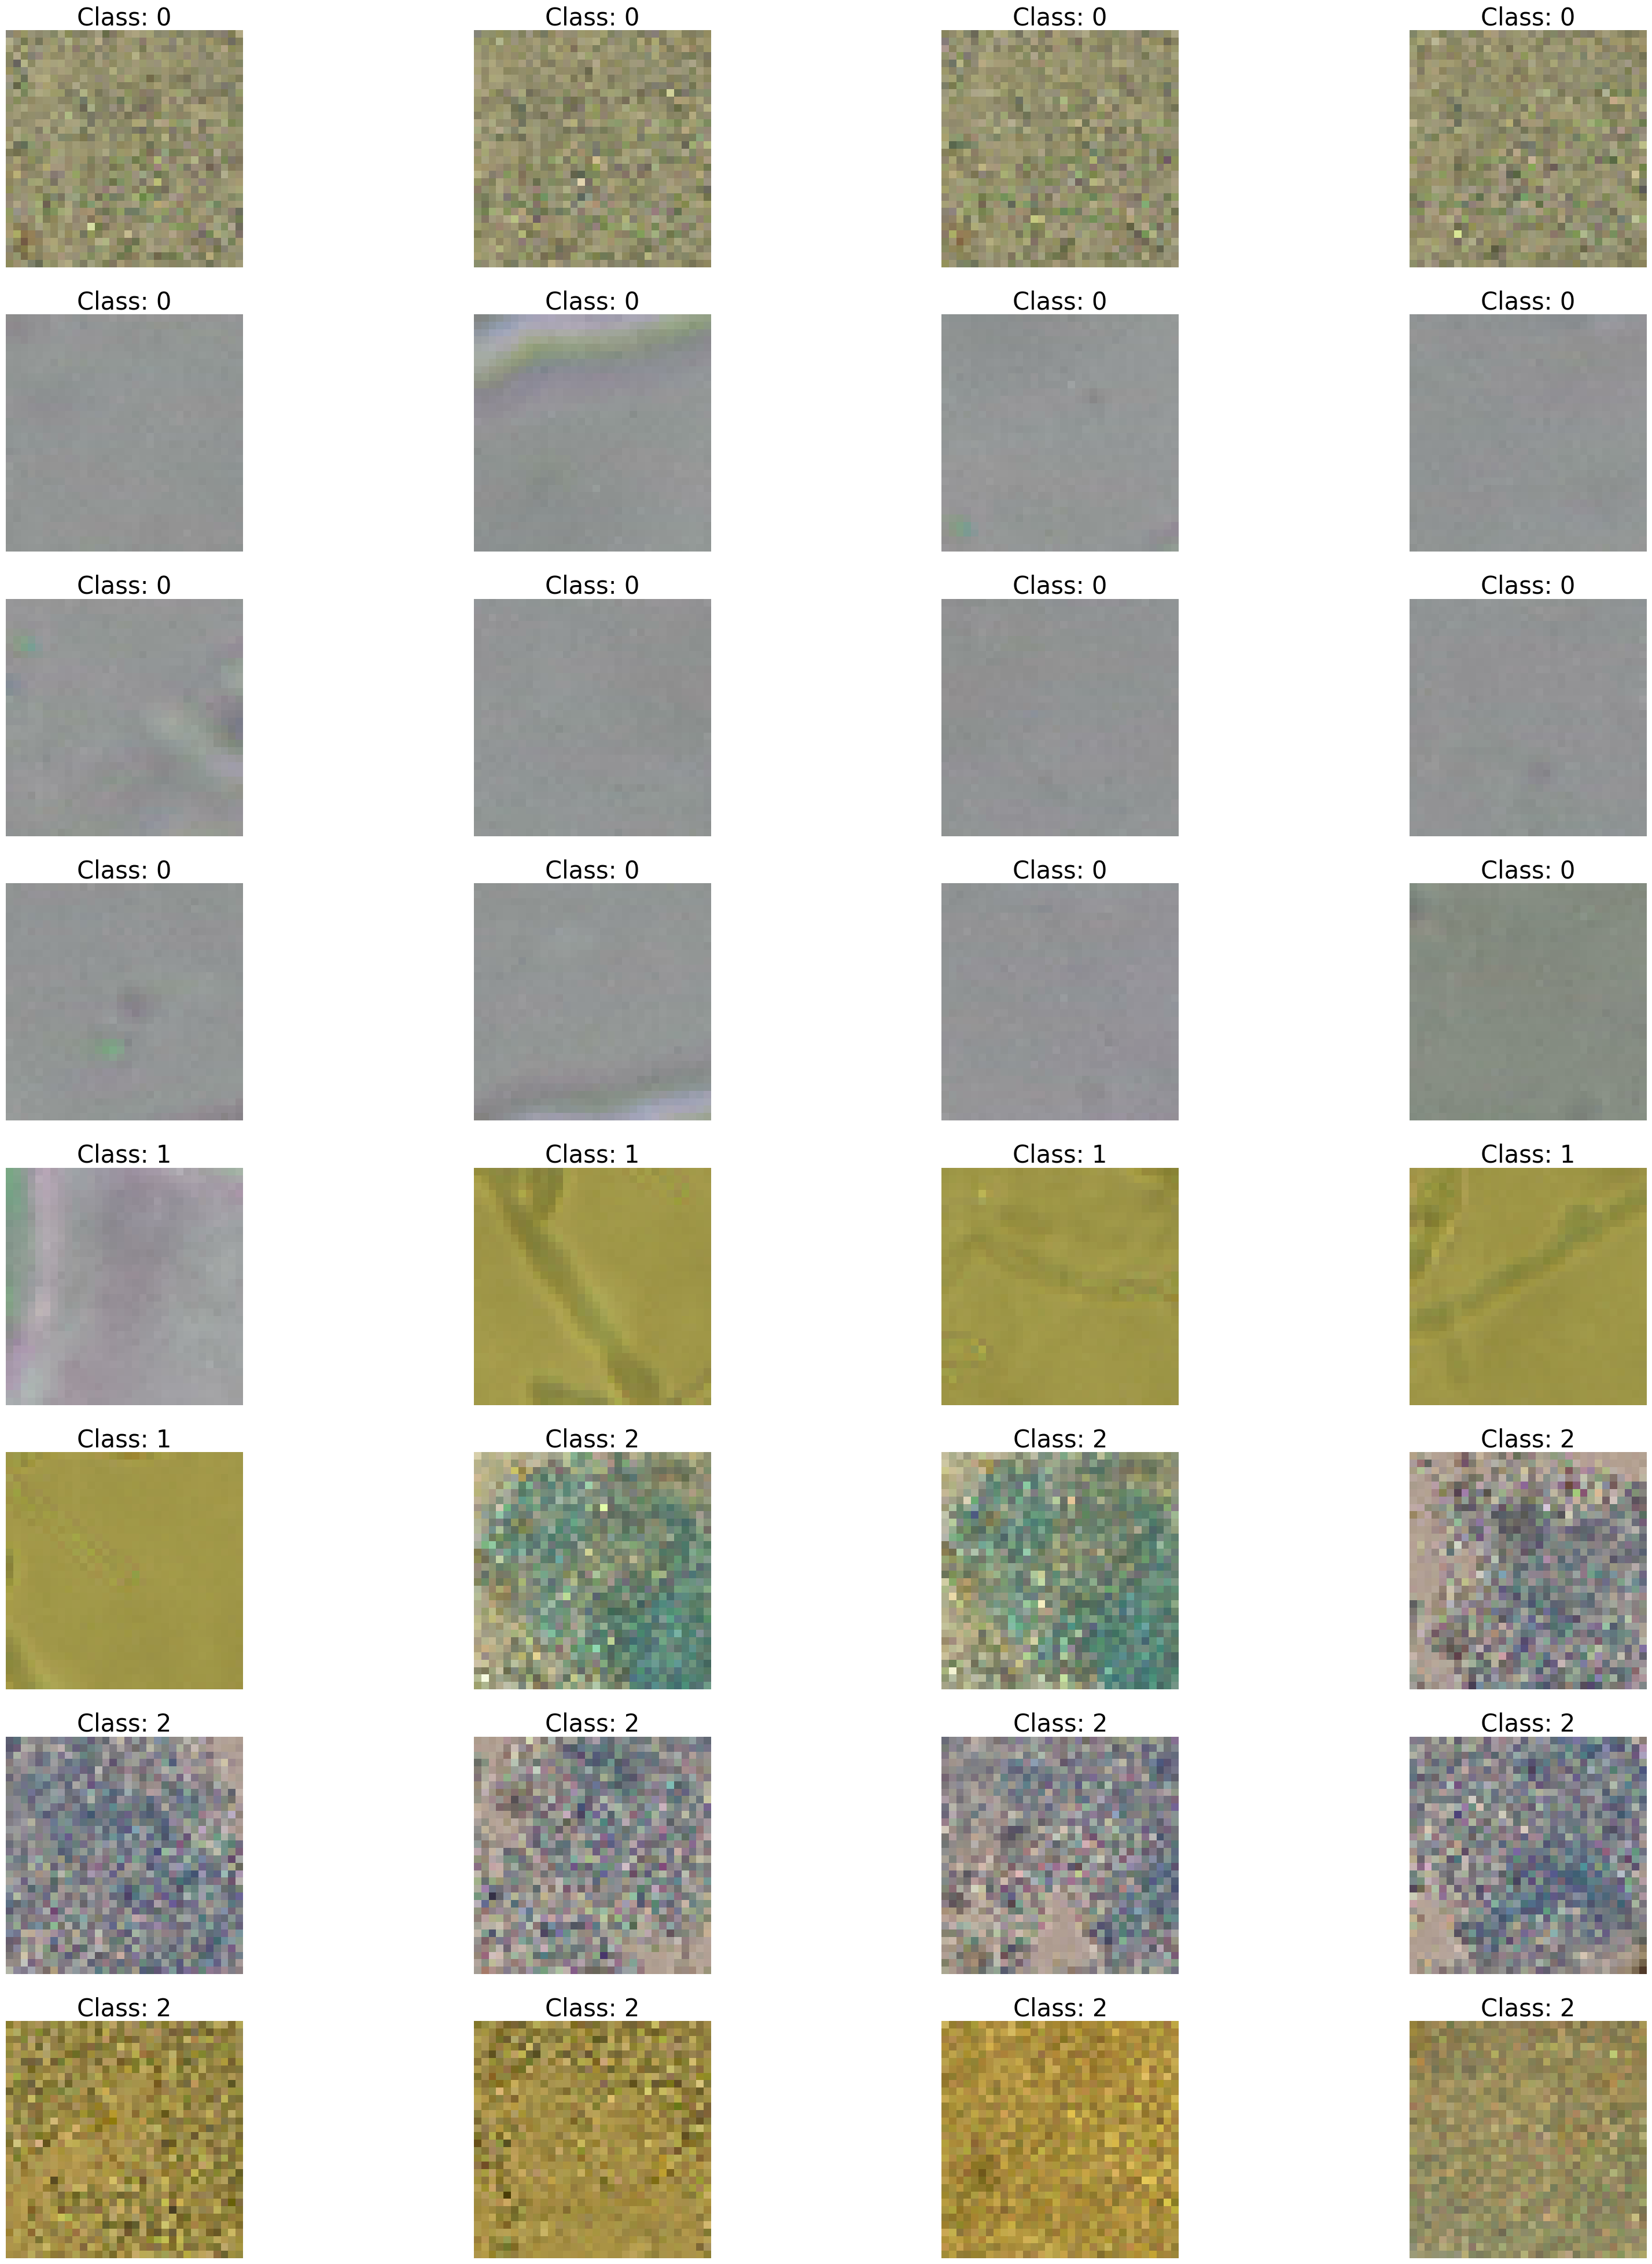

In [16]:
display_images(tf_data_blurred)

### Checking the Number of Data in Each Class

Label
H1    4388
H2    2260
H3     805
H5     729
H6     695
Name: count, dtype: int64


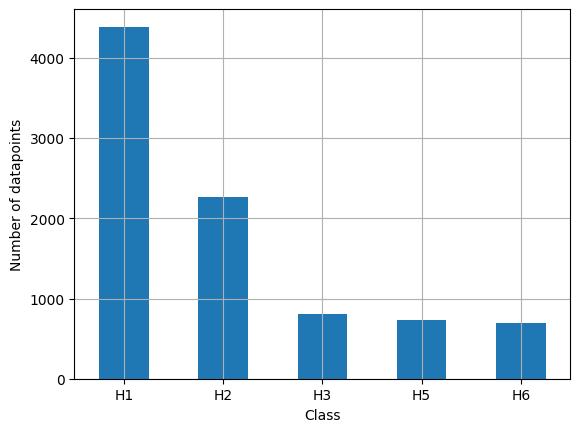

In [17]:
Cat = Defungi_data_clear["Label"].value_counts()
print(Cat)
Defungi_data_clear["Label"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Class")
plt.ylabel("Number of datapoints")
plt.show()

Label
H1    4388
H2    2260
H3     805
H5     729
H6     695
Name: count, dtype: int64


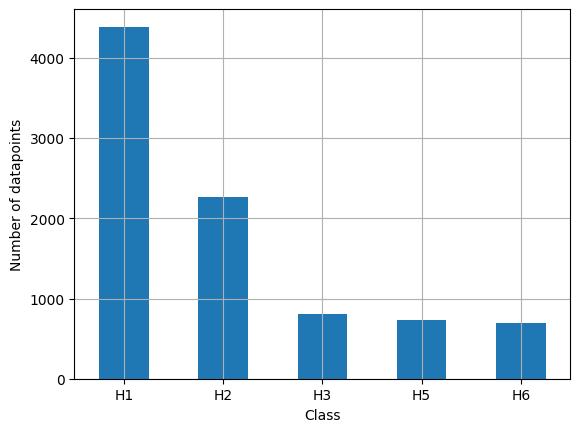

In [17]:
Cat = Defungi_data_clear["Label"].value_counts()
print(Cat)
Defungi_data_clear["Label"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Class")
plt.ylabel("Number of datapoints")
plt.show()

### Data Augmentation

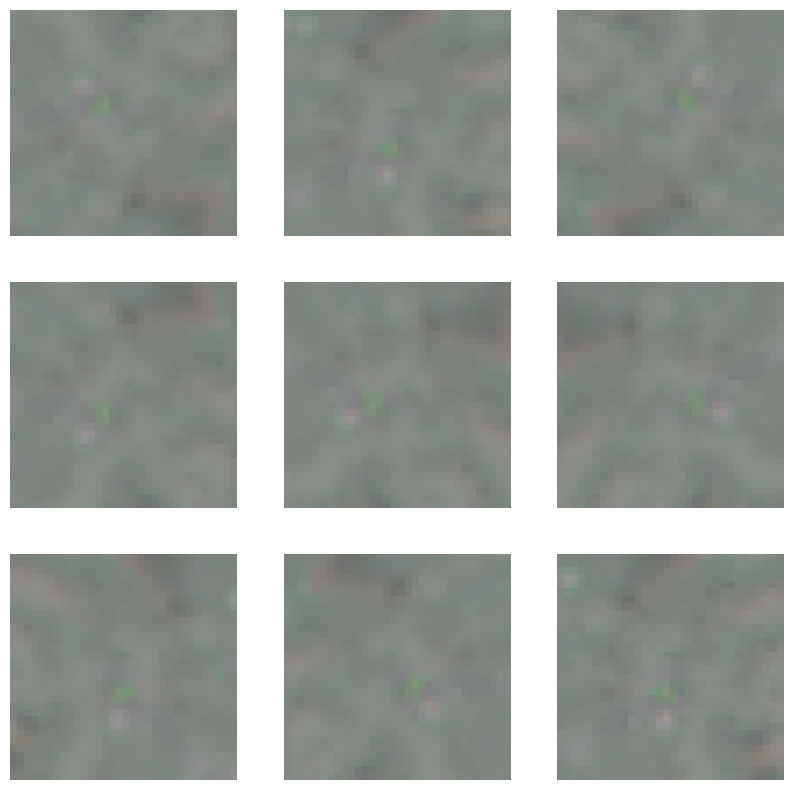

In [21]:
# Data Augmentation of the training images

data_augmentation = keras.Sequential(
    [tf.keras.layers.RandomFlip("horizontal_and_vertical"),
     tf.keras.layers.RandomRotation(factor = (-0.5, 0.5)),
    ])

data_train = data_train.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

plt.figure(figsize=(10, 10))
for images, _ in data_train.take(2):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [22]:
data_augmentation = keras.Sequential(
    [tf.keras.layers.RandomFlip("horizontal_and_vertical"),
     tf.keras.layers.RandomRotation(factor = (-0.5, 0.5)),
    ])

### ResNet Model 

In [23]:
# Load training and testing data from the dataset using Keras
# Original images are 500x500

def model_fungi_book(data_shape, number_of_classes, filter_size):

    inputs = keras.Input(shape = data_shape)
#    keras.regularizers.l1_l2(l1=0.01, l2=0.001)
    x = data_augmentation(inputs)
    x = tf.keras.layers.Rescaling(1/255.0)(x)

    x = tf.keras.layers.Conv2D(filters = filter_size, kernel_size = 7, strides = 2, padding = "same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPool2D(pool_size = 3, strides = 2, padding = "same")(x)

    prev_filters = 64
    residual = x  # Set aside residual
        
    for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
        if filters == prev_filters:
            strides = 1
        else:
            strides = 2
        x = tf.keras.layers.SeparableConv2D(filters = filters, kernel_size = 3, strides = strides, padding = "same")(residual)
#        x = tf.keras.layers.Conv2D(filters = filters, kernel_size = 3, strides = strides, padding = "same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters = filters, kernel_size = 3, strides = strides, padding = "same")(x)
#        x = tf.keras.layers.Conv2D(filters = filters, kernel_size = 3, strides = strides, padding = "same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        if filters != prev_filters:
            residual = tf.keras.layers.SeparableConv2D(filters = filters, kernel_size = 1, strides = 4)(residual)
            
        x = tf.keras.layers.add([x, residual])  # Add back residual
        residual = tf.keras.layers.Activation("relu")(x)
        prev_filters = filters
            
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)

    if number_of_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = number_of_classes

    outputs = tf.keras.layers.Dense(units, activation=activation)(x)
    
    return keras.Model(inputs, outputs)

model = model_fungi_book(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 64)
model.summary()
# keras.utils.plot_model(model, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 32, 32, 3)            0         ['input_2[0][0]']             
                                                                                                  
 rescaling (Rescaling)       (None, 32, 32, 3)            0         ['sequential_1[0][0]']        
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 64)           9472      ['rescaling[0][0]']           
                                                                                              

### MLP-Mixer Model

In [345]:
# Load training and testing data from the dataset using Keras
# Original images are 500x500
def model_fungi_conv_mixer(data_shape, number_of_classes, filter_size):

    inputs = keras.Input(shape = data_shape)
    x = data_augmentation(inputs)
    x = tf.keras.layers.Rescaling(1/255.0)(x)

    # Conv2D is a class that spatial convolution over images
    # filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution)
    # kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions.
    # strides: An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. Can be a single integer to specify the same value for all spatial dimensions. Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.
    # padding: one of "valid" or "same" (case-insensitive). "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input. When padding="same" and strides=1, the output has the same size as the input.
    # in https://www.kaggle.com/code/banddaniel/fungus-detect-w-10cv-custom-convmixer-f1-0-85/notebook
    # filter = 256
    x = tf.keras.layers.Conv2D(filters = filter_size, kernel_size = 2, strides = 2, padding = "same")(x)
    x = tf.keras.layers.Activation("gelu")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    vector_of_ones = np.ones(8, dtype = int)
#    print(vector_of_ones)
    kernel_size = 2
    residual = x  # Set aside residual
#    for size in 256 * vector_of_ones:
    for size in filter_size * vector_of_ones:
        x = tf.keras.layers.DepthwiseConv2D(kernel_size = kernel_size, strides = 1, padding = 'same')(x)
        x = tf.keras.layers.Activation('gelu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Add()([x, residual])
        x = tf.keras.layers.Conv2D(filters = size, kernel_size = 1)(x)
        x = tf.keras.layers.Activation('gelu')(x)
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    if number_of_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = number_of_classes

    outputs = tf.keras.layers.Dense(units, activation = activation)(x)
    
    return keras.Model(inputs, outputs)

model = model_fungi_conv_mixer(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 256)
model.summary()

Model: "model_154"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_156 (InputLayer)      [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 sequential_4 (Sequential)   (None, 32, 32, None)         0         ['input_156[0][0]']           
                                                                                                  
 rescaling_155 (Rescaling)   (None, 32, 32, 3)            0         ['sequential_4[33][0]']       
                                                                                                  
 conv2d_675 (Conv2D)         (None, 16, 16, 256)          3328      ['rescaling_155[0][0]']       
                                                                                          

### Model Compilation

In [24]:
# training method "sgd" means that the model will be trained
# using stochastic gradient descent
# learning_rate is 0.001 (defaults learning rate is 0.01)
learning_rate = 0.0001
sgd = SGD(learning_rate = learning_rate)
Adamar = Adam(learning_rate = learning_rate)
#Adamar = AdamW(learning_rate = learning_rate)
epochs = 10

callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")]
#scaler = preprocessing.StandardScaler().fit(data_train)

model.compile(
    optimizer = Adamar,
    loss = "sparse_categorical_crossentropy",
    metrics = ['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 2, name = "top_2_acc", dtype = None)])
#    metrics = ["accuracy"])

#acc_loss = model.fit(
#    data_train,
#    epochs = epochs,
#    callbacks = callbacks,
#    validation_data = data_test)

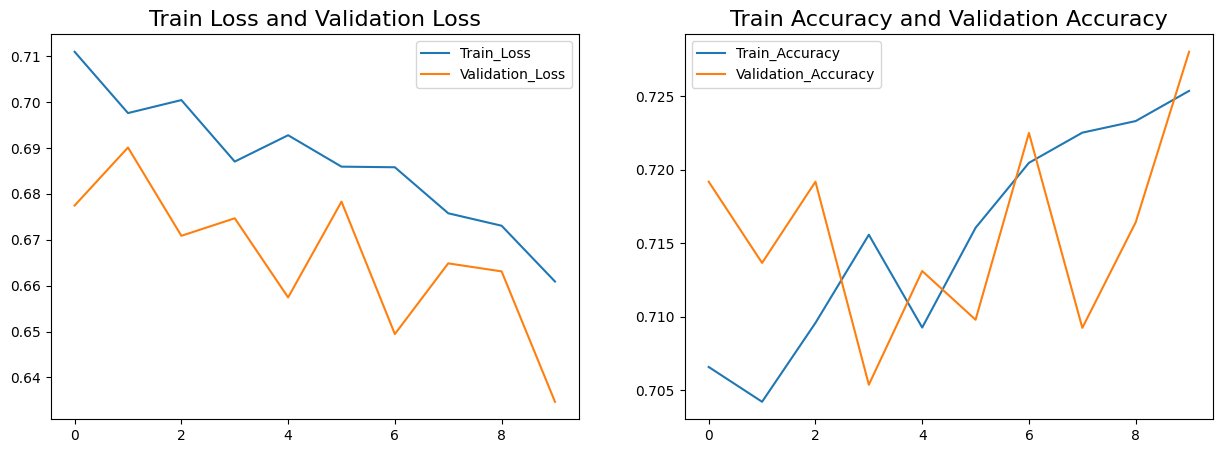

In [190]:
acc_loss_show = pd.DataFrame(acc_loss.history)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(acc_loss_show['loss'],label='Train_Loss')
plt.plot(acc_loss_show['val_loss'],label='Validation_Loss')
plt.title('Train Loss and Validation Loss',fontsize = 16)
plt.legend()
plt.subplot(1,2,2)
plt.plot(acc_loss_show['accuracy'],label='Train_Accuracy')
plt.plot(acc_loss_show['val_accuracy'],label='Validation_Accuracy')
plt.title('Train Accuracy and Validation Accuracy',fontsize = 16)
plt.legend()

In [339]:
def variance_of_Laplacian(image):
    ker_edge_detect = np.array([[ 0, -1,  0], 
                                [-1,  4, -1], 
                                [ 0, -1,  0]])
    image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    img = cv2.filter2D(src = image_gray, ddepth = -1, kernel = ker_edge_detect)
    variance = np.var(img)
    return variance

Path = "C:\\Users\\olgat\\OneDrive\\PYTHON\\ML\\Defungi_S\\H1\\H1_1a_22.jpg"
image = cv2.imread(Path)
print(type(image))
print(image.shape)
print(type(images.numpy()))
print(images.numpy().shape)
var = variance_of_Laplacian(image)
print(var)
var = variance_of_Laplacian(np.array(images[31,:,:,:]))
print(var)

<class 'numpy.ndarray'>
(500, 500, 3)
<class 'numpy.ndarray'>
(32, 128, 128, 3)
1.4040138769760004
18.53733


### K-fold Validation

In [30]:
print(type(data_train))
print(data_train)

<class 'tensorflow.python.data.ops.map_op._ParallelMapDataset'>
<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 32, 32, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [47]:
fold_hists = []
test_evals = []
test_preds = []

X_train = []
y_train = []

kf = KFold(n_splits = project_folds, shuffle = True, random_state = project_seed)

# for i, (train_index, val_index) in enumerate(kf.split(data_train['img'], train_df['label'])):
for images, labels in data_train:

    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())

for i, (train_indices, val_indices) in enumerate(kf.split(X_train, y_train)):

    print('%' * 100)
    print('The training of ' + str(i + 1) + 'fold')
    
    X_train_fold = [X_train[k] for k in train_indices]
    y_train_fold = [y_train[k] for k in train_indices]
    
    X_val_fold = [X_train[k] for k in val_indices]
    y_val_fold = [y_train[k] for k in val_indices]
    
    # Creating the pipeline
    train_loader = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold))
    train_dataset = (train_loader
                     .batch(project_batch_size)
                     .shuffle(project_batch_size * project_folds)
                     .prefetch(project_auto))
    
    validation_loader = tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold))
    validation_dataset = (validation_loader
                          .batch(project_batch_size)
                          .prefetch(project_auto))
    
    # Training
    hist = model.fit(train_dataset,
                     epochs = project_epochs,
                     batch_size = project_batch_size,
                     callbacks = callbacks,
                     validation_data = validation_dataset)

    #acc_loss = model.fit(
#    data_train,
#    epochs = epochs,
#    callbacks = callbacks,
#    validation_data = data_test)
    
    fold_hists.append(hist)
    
    # Test evaluation
#    test_eval = model.evaluate(test_dataset)
    test_eval = model.evaluate(data_test)
    test_evals.append(test_eval)
    print('Test Loss: {0:.3f}'.format(test_eval[0]))
    print('Test Accuracy: {0:.3f} %'.format(test_eval[1]*100))
    print('Test Sparse Top 2 Accuracy: {0:.2f} %'.format(test_eval[2]*100))
    
    # Test set prediction
    test_take1 =  data_test.take(-1)
    test_take1_ = list(test_take1)
    pred = model.predict(test_take1)
    test_preds.append(pred)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The training of 1fold
Epoch 1/4
7/7 [==============================] - 2s 284ms/step - loss: 0.9282 - accuracy: 0.5991 - top_2_acc: 0.8705 - val_loss: 1.5492 - val_accuracy: 0.2432 - val_top_2_acc: 0.7432
Epoch 2/4
7/7 [==============================] - 3s 395ms/step - loss: 0.8734 - accuracy: 0.6115 - top_2_acc: 0.9189 - val_loss: 1.5459 - val_accuracy: 0.2432 - val_top_2_acc: 0.7432
Epoch 3/4
7/7 [==============================] - 5s 856ms/step - loss: 0.8448 - accuracy: 0.6385 - top_2_acc: 0.9167 - val_loss: 1.5440 - val_accuracy: 0.2432 - val_top_2_acc: 0.7432
Epoch 4/4
56/56 [==============================] - 13s 231ms/step - loss: 1.5398 - accuracy: 0.4944 - top_2_acc: 0.7489
Test Loss: 1.540
Test Accuracy: 49.444 %
Test Sparse Top 2 Accuracy: 74.89 %
56/56 [==============================] - 6s 110ms/step
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [50]:
X_train = []
y_train = []

k = 0
for images, labels in data_train:
    k = k = 1
    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())
    if k < 10:
        print(len(labels.numpy()))
        print(labels.numpy())
        print(len(images.numpy()))
        print(images.numpy())
print(len(X_train))
print(len(y_train))
print(data_train)

128
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
128
[[[[115.43359  114.49609  127.84375 ]
   [145.85156  157.72656  153.91406 ]
   [153.26172  157.19922  148.13672 ]
   ...
   [132.0625   137.6875   131.375   ]
   [132.6875   142.6875   134.6875  ]
   [127.       136.3125   130.375   ]]

  [[122.21094  128.       124.1875  ]
   [131.       154.0586   134.0664  ]
   [150.60547  143.6875   134.48047 ]
   ...
   [129.03516  135.03516  131.03516 ]
   [122.3125   128.3125   124.3125  ]
   [129.33203  138.33203  133.33203 ]]

  [[123.80078  129.21094  107.71094 ]
   [114.72266  121.19531  106.19531 ]
   [119.1875   110.3125   108.99609 ]
   ...
   [130.4375   136.4375   136.4375  ]
   [128.9375   132.9375   131.9375  ]
   [138.25     142.25     141.25    ]]

  ...

  [[141.61328

In [752]:
class AccuracyCallback(keras.callbacks.Callback):
    def __init__(self):
        self.accuracies = [] # a list to store the accuracy scores for each fold
        self.losses = [] # a list to store the accuracy scores for each fold

    def on_train_begin(self, logs = None):
        global glob_fold
        glob_fold += 1
        print()
        print("Training of fold {}".format(glob_fold))
    
    def on_epoch_end(self, epoch, logs = None):
        self.accuracies.append(logs['accuracy']) # append the accuracy score to the list
        self.losses.append(logs['loss']) # append the loss to the list


In [753]:
from sklearn.metrics import make_scorer, accuracy_score

X_train = []
y_train = []
X_test = []
y_test = []

for images, labels in data_train:

    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())
    
for images, labels in data_test:

    X_test.extend(images.numpy())
    y_test.extend(labels.numpy())

# Define a Keras NN model
def create_model():
    model = model_fungi_book(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 64)
#    model = model_fungi_conv_mixer(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 256)
    learning_rate = project_learning_rate
    sgd = SGD(learning_rate = learning_rate)
    Adamar = Adam(learning_rate = learning_rate)
    #Adamar = AdamW(learning_rate = learning_rate)
    
#    callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")]
    
    model.compile(
        optimizer = Adamar,
        loss = "sparse_categorical_crossentropy",
        metrics = ['accuracy'])
    return model

# Wrap the Keras model with scikit-learn (shuffle is set to TRUE by default)
accuracy_callback = AccuracyCallback()
clf = KerasClassifier(model = create_model, epochs = project_epochs, 
                      batch_size = project_batch_size, loss = True,
                      callbacks = accuracy_callback)

# Create a pipeline with scaling and NN model
pipe = Pipeline([
#    ('scaler', StandardScaler()), # This will standardize the features
    ('clf', clf) # This will fit the NN model
])

# Perform 5-fold cross-validation on the pipeline
scoring = {"accuracy": "accuracy",
           "loss": "neg_log_loss"}

#scoring = "accuracy"
print(scoring)

glob_fold = 0
cv_results = cross_validate(pipe, X_train, y_train, cv = project_folds, scoring = make_scorer(accuracy_score),
                            return_train_score = True, return_estimator = True)


{'accuracy': 'accuracy', 'loss': 'neg_log_loss'}

Training of fold 1
Epoch 1/4
7/7 [==============================] - 30s 390ms/step - loss: 1.5477 - accuracy: 0.4232
Epoch 2/4
7/7 [==============================] - 3s 393ms/step - loss: 1.3850 - accuracy: 0.5569
Epoch 3/4
7/7 [==============================] - 3s 412ms/step - loss: 1.2277 - accuracy: 0.5592
Epoch 4/4
7/7 [==============================] - 1s 108ms/step

Training of fold 2
Epoch 1/4
7/7 [==============================] - 24s 435ms/step - loss: 1.5817 - accuracy: 0.3072
Epoch 2/4
7/7 [==============================] - 3s 456ms/step - loss: 1.4419 - accuracy: 0.5287
Epoch 3/4
7/7 [==============================] - 3s 443ms/step - loss: 1.3061 - accuracy: 0.5498
Epoch 4/4
7/7 [==============================] - 1s 111ms/step


In [754]:
test_preds = []

for i in range(project_folds):
    print("Prediction: estimator {}".format(i + 1))
    y_pred = cv_results['estimator'][i].predict(X_test)
    test_preds.append(y_pred)

preds = np.mean(test_preds, axis = 0)
last_pred = np.argmax(preds, axis = 0)

Prediction: estimator 1
54/54 [==============================] - 8s 149ms/step
Prediction: estimator 2
54/54 [==============================] - 7s 121ms/step


In [755]:
print(preds)
print(last_pred)

print(cv_results)
print(cv_results['estimator'][0]['clf'].callbacks.accuracies)
print(cv_results['estimator'][1]['clf'].callbacks.accuracies)
print(cv_results['estimator'][0]['clf'].callbacks.losses)
print(cv_results['estimator'][1]['clf'].callbacks.losses)

print(test_preds)

[0. 0. 0. ... 0. 0. 0.]
0
{'fit_time': array([41.07021689, 35.35622334]), 'score_time': array([2.06910872, 2.31187773]), 'estimator': [Pipeline(steps=[('clf',
                 KerasClassifier(batch_size=128, callbacks=<__main__.AccuracyCallback object at 0x000001194B247FA0>, epochs=4, loss=True, model=<function create_model at 0x000001194B2DA1F0>))]), Pipeline(steps=[('clf',
                 KerasClassifier(batch_size=128, callbacks=<__main__.AccuracyCallback object at 0x000001194B247400>, epochs=4, loss=True, model=<function create_model at 0x000001194B2DA1F0>))])], 'test_score': array([0.48886284, 0.48886284]), 'train_score': array([0.48886284, 0.48886284])}
[0.4232122004032135, 0.5568581223487854, 0.5592027902603149, 0.5767878293991089]
[0.3071512281894684, 0.5287221670150757, 0.5498241782188416, 0.5451348423957825]
[1.5477139949798584, 1.385015606880188, 1.2277233600616455, 1.1159504652023315]
[1.581695556640625, 1.4419336318969727, 1.3060965538024902, 1.1910662651062012]
[array([0

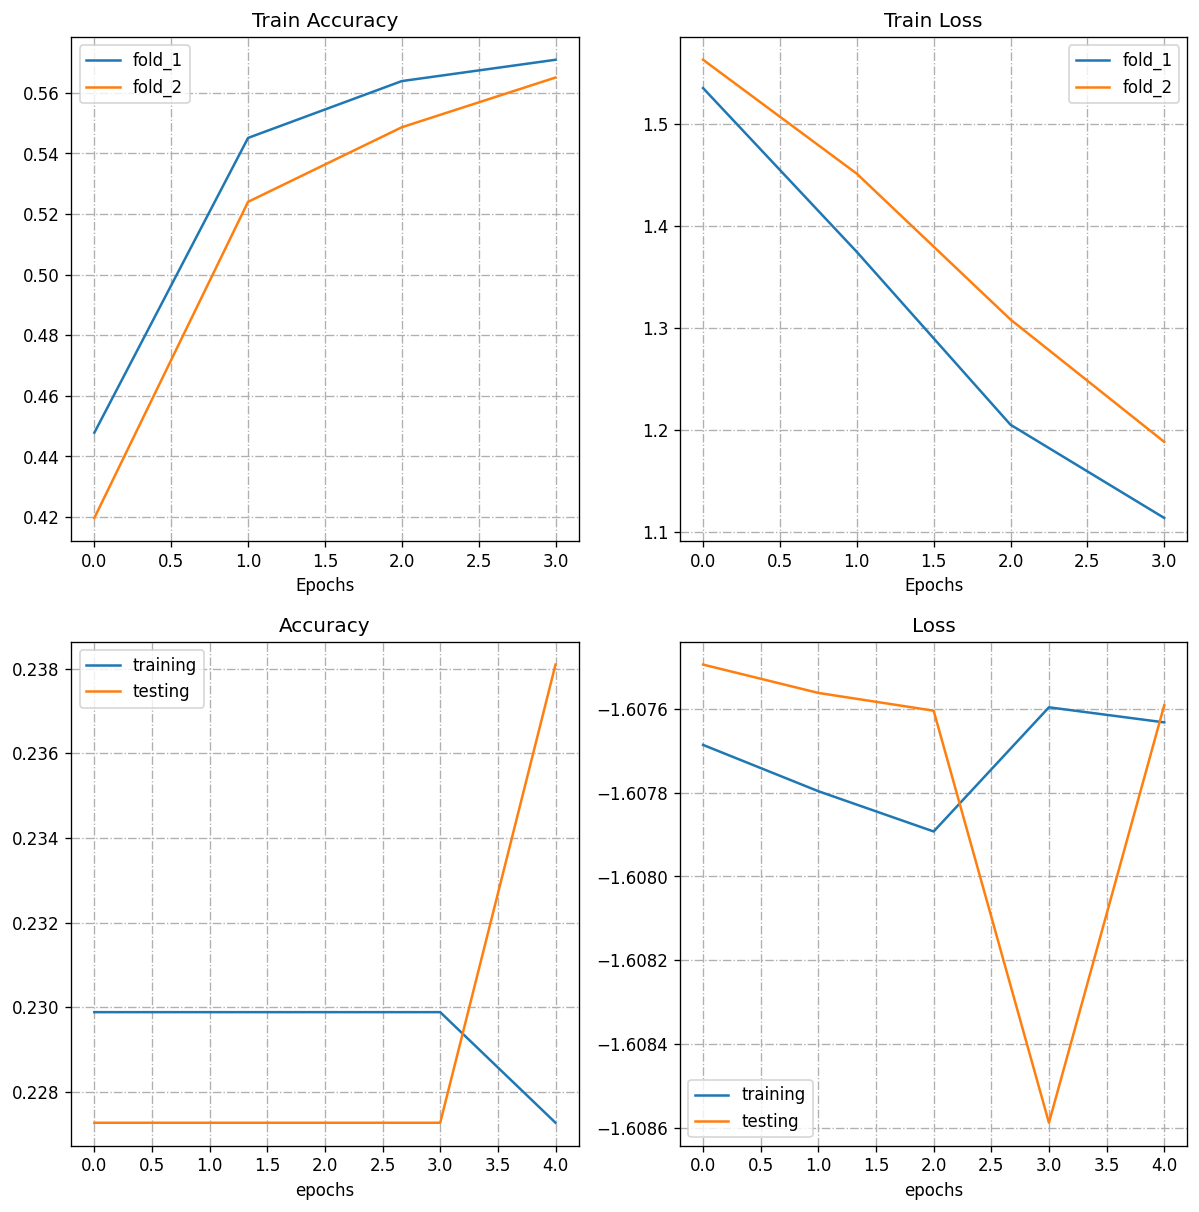

In [748]:
fig, axs = plt.subplots(2,2, figsize = (12,12) ,dpi = 120)

folds_name = []
fig_3_name = []
fig_4_name = []

axs[0][0].set_title('Train Accuracy')
axs[0][0].grid(linestyle = 'dashdot')
axs[0][0].set_xlabel('Epochs', fontsize = 10)
for i in range(project_folds):
    axs[0][0].plot(cv_results['estimator'][i]['clf'].callbacks.accuracies)
    folds_name.append('fold_' + str(i + 1) )
axs[0][0].legend(folds_name, fontsize = 10)


axs[0][1].set_title('Train Loss')
axs[0][1].grid(linestyle = 'dashdot')
axs[0][1].set_xlabel('Epochs', fontsize = 10)
for i in range(project_folds):
    axs[0][1].plot(cv_results['estimator'][i]['clf'].callbacks.losses)
axs[0][1].legend(folds_name, fontsize = 10)


axs[1][0].set_title('Accuracy')
axs[1][0].grid(linestyle = 'dashdot')
axs[1][0].set_xlabel('epochs', fontsize = 10)
axs[1][0].plot(scores['train_accuracy'])
axs[1][0].plot(scores['test_accuracy'])
fig_3_name.append('training')
fig_3_name.append('testing')
axs[1][0].legend(fig_3_name, fontsize = 10)


axs[1][1].set_title('Loss')
axs[1][1].grid(linestyle = 'dashdot')
axs[1][1].set_xlabel('epochs', fontsize = 10)
axs[1][1].plot(scores['train_loss'])
axs[1][1].plot(scores['test_loss'])
fig_4_name.append('training')
fig_4_name.append('testing')
axs[1][1].legend(fig_4_name, fontsize = 10)

In [665]:
fold_hists = []
test_evals = []
test_preds = []

X_train = []
y_train = []
X_test = []
y_test = []

for images, labels in data_train:

    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())
    
for images, labels in data_test:

    X_test.extend(images.numpy())
    y_test.extend(labels.numpy())

# Define a Keras NN model
def create_model():
    model = model_fungi_book(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 64)
#    model = model_fungi_conv_mixer(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 256)
    learning_rate = project_learning_rate
    sgd = SGD(learning_rate = learning_rate)
    Adamar = Adam(learning_rate = learning_rate)
    #Adamar = AdamW(learning_rate = learning_rate)
    
#    callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")]
    
    model.compile(
        optimizer = Adamar,
        loss = "sparse_categorical_crossentropy",
        metrics = ['accuracy'])
    return model

accuracy_callback = AccuracyCallback()
# Wrap the Keras model with scikit-learn (shuffle is set to TRUE by default)
clf = KerasClassifier(model = create_model, epochs = project_epochs,
                      batch_size = project_batch_size, loss = True, callbacks = accuracy_callback)

# Create a pipeline with scaling and NN model
pipe = Pipeline([('clf', clf) # This will fit the NN model
                ])

# Perform 5-fold cross-validation on the pipeline
#scoring = {"accuracy": "accuracy",
#           "loss": "neg_log_loss"}

scoring = {"accuracy": "accuracy"}
print(scoring)

#def print_fold(fold, score):
#    print(f"Fold {fold} - Score: {score}")
    
cv = KFold(n_splits = project_folds, shuffle = True, random_state = project_seed)

model = create_model()
fold = 0
for train_indices, val_indices in cv.split(X_train):
    X_train_fold = [X_train[k] for k in train_indices]
    y_train_fold = [y_train[k] for k in train_indices]
    
    X_val_fold = [X_train[k] for k in val_indices]
    y_val_fold = [y_train[k] for k in val_indices]

    fold += 1
    print("")
    print(f"Fold {fold} Training")
    
    # fit the pipeline on the training set and score it on the test set
    pipe.fit(X_train_fold, y_train_fold)
#    score_val = pipe.score(X_val_fold, y_val_fold)
    # call the custom callback function with the fold number and the score

    model = pipe.named_steps['clf'].model_
    fold_hists.append(model)
    
    print(f"Fold {fold} Model Evaluation")
    test_eval = model.evaluate(data_test)
    test_evals.append(test_eval)
    print('Test Loss: {0:.3f}'.format(test_eval[0]))
    print('Test Accuracy: {0:.3f} %'.format(test_eval[1]*100))
    
    # Test set prediction
    print(f"Fold {fold} Prediction")
    pred = pipe.predict(X_test)
    test_preds.append(pred)
    
#cv_results = cross_validate(pipe, X_train, y_train, cv = cv, scoring = scoring,
#                        return_train_score = True, return_estimator = True)

{'accuracy': 'accuracy'}

Fold 1 Training
Epoch 1/4
7/7 [==============================] - 31s 1s/step - loss: 1.5719 - accuracy: 0.3189
Epoch 2/4
7/7 [==============================] - 7s 967ms/step - loss: 1.4169 - accuracy: 0.5029
Epoch 3/4
7/7 [==============================] - 7s 1s/step - loss: 1.2601 - accuracy: 0.5334
Epoch 4/4
7/7 [==============================] - 7s 948ms/step - loss: 1.1585 - accuracy: 0.5592
Fold 1 Model Evaluation
54/54 [==============================] - 19s 329ms/step - loss: 1.5540 - accuracy: 0.4887
Test Loss: 1.554
Test Accuracy: 48.872 %
Fold 1 Prediction
54/54 [==============================] - 14s 233ms/step

Fold 2 Training
Epoch 1/4
7/7 [==============================] - 30s 970ms/step - loss: 1.5736 - accuracy: 0.3271
Epoch 2/4
7/7 [==============================] - 6s 829ms/step - loss: 1.4539 - accuracy: 0.5006
Epoch 3/4
7/7 [==============================] - 6s 828ms/step - loss: 1.2994 - accuracy: 0.5533
Epoch 4/4
7/7 [======================

In [131]:
from sklearn.model_selection import GridSearchCV

X_train = []
y_train = []
X_test = []
y_test = []

for images, labels in data_train:

    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())
    
for images, labels in data_test:

    X_test.extend(images.numpy())
    y_test.extend(labels.numpy())

# Define a Keras NN model
def create_model(learning_rate = project_learning_rate):
    model = model_fungi_book(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 64)
#    model = model_fungi_conv_mixer(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 256)
#    learning_rate = project_learning_rate
#    sgd = SGD(learning_rate = learning_rate)
    Adamar = Adam(learning_rate = learning_rate)
    #Adamar = AdamW(learning_rate = learning_rate)
    
#    callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")]
    
    model.compile(
#        optimizer = Adamar,
        loss = 'sparse_categorical_crossentropy',
        metrics = 'accuracy')
    return model

# Wrap the Keras model with scikit-learn (shuffle is set to TRUE by default)
clf = KerasClassifier(model = create_model, batch_size = project_batch_size, loss = True)

# Create a pipeline with scaling and NN model
pipe = Pipeline([
    ('clf', clf) # This will fit the NN model
])

# Perform K-fold cross-validation on the pipeline
scoring = {"accuracy": "accuracy",
           "loss": "neg_log_loss"}

param_grid = {'epochs': [25], # Number of epochs to train the model
              'optimizer': [tf.keras.optimizers.Adam()],
# 1st evaluation (the best result is 0.001, 128
              'optimizer__learning_rate': [0.001, 0.0005, 0.0001],
# 2nd evaluation
#              'optimizer__learning_rate': [0.0005, 0.001, 0.002, 0.005],
              'batch_size': [32, 64, 128]
#              'batch_size': [128]
             }

gs = GridSearchCV(estimator = clf, param_grid = param_grid, scoring = 'accuracy', cv = 2)

# Fit the grid search on the training data
gs.fit(X_train, y_train)

# Print the best parameters and score
print(gs.best_params_)
print(gs.best_score_)

Epoch 1/25
111/111 [==============================] - 19s 100ms/step - loss: 1.1527 - accuracy: 0.5361
Epoch 2/25
111/111 [==============================] - 11s 99ms/step - loss: 1.0432 - accuracy: 0.5674
Epoch 3/25
111/111 [==============================] - 11s 102ms/step - loss: 1.0081 - accuracy: 0.5909
Epoch 4/25
111/111 [==============================] - 11s 103ms/step - loss: 0.9624 - accuracy: 0.6092
Epoch 5/25
111/111 [==============================] - 12s 104ms/step - loss: 0.9116 - accuracy: 0.6340
Epoch 6/25
111/111 [==============================] - 12s 109ms/step - loss: 0.9102 - accuracy: 0.6323
Epoch 7/25
111/111 [==============================] - 12s 112ms/step - loss: 0.8780 - accuracy: 0.6493
Epoch 8/25
111/111 [==============================] - 14s 125ms/step - loss: 0.8611 - accuracy: 0.6577
Epoch 9/25
111/111 [==============================] - 16s 145ms/step - loss: 0.8464 - accuracy: 0.6577
Epoch 10/25
111/111 [==============================] - 15s 138ms/step - lo

In [371]:
clf.get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'class_weight'])

KeyError: 'train_loss'

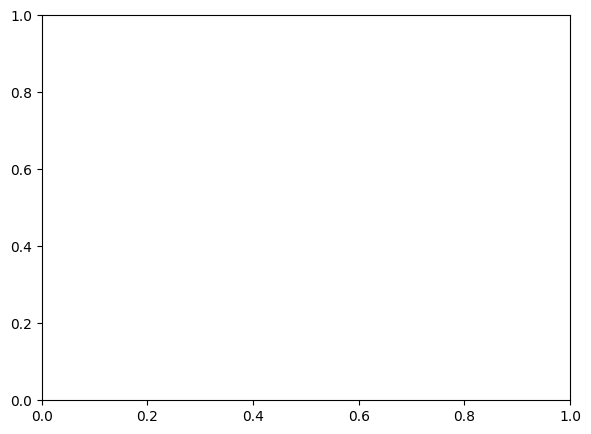

In [710]:
acc_loss_show = pd.DataFrame(cv_results)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(acc_loss_show['train_loss'], label = 'train_loss')
plt.plot(acc_loss_show['test_loss'], label = 'test_loss')
plt.title('Train Loss and Test Loss', fontsize = 16)
plt.legend()

plt.subplot(1,2,2)
plt.plot(acc_loss_show['train_accuracy'], label = 'train_accuracy')
plt.plot(acc_loss_show['test_accuracy'], label = 'test_accuracy')
plt.title('Train Accuracy and Test Accuracy', fontsize = 16)
plt.legend()

In [152]:
y_pred = cv_results['estimator'][9].predict(X_test)

13/13 [==============================] - 11s 866ms/step


In [122]:
print(gs)

GridSearchCV(cv=2,
             estimator=KerasClassifier(batch_size=128, loss=True, model=<function create_model at 0x00000154BA375430>),
             param_grid={'batch_size': [32, 64, 128], 'epochs': [25],
                         'optimizer': [<keras.src.optimizers.adam.Adam object at 0x00000154BA321AC0>],
                         'optimizer__learning_rate': [0.001, 0.0001]},
             scoring='accuracy')


In [130]:
y_pred = gs.predict(X_test)
print(gs.best_params_)
cv_res = pd.DataFrame(gs.cv_results_)
print(cv_res)

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [129]:
for i in len(gs.param_grid['n_estimators']):
    params = gs.cv_results_['params'][gs.cv_results_['rank_test_score'] == i][0]
    # Set the parameters of the GridSearchCV object
    gs.set_params(**params)
    # Predict or score on the test data
    y_pred = gs.predict(X_test)
    y_score = gs.score(X_test, y_test)

KeyError: 'n_estimators'

In [158]:
# Convert cv_results to a data frame
df = pd.DataFrame(cv_results)

# Save the data frame to a csv file
df.to_csv('cv_results.csv')

In [159]:
# Save the models from cv_results to files
for i, model in enumerate(cv_results['estimator']):
    joblib.dump(model, f'model_{i}.pkl')

# Load the models from the files
models = []
for i in range(len(cv_results['estimator'])):
    model = joblib.load(f'model_{i}.pkl')
    models.append(model)

INFO:tensorflow:Assets written to: C:\Users\olgat\AppData\Local\Temp\tmpacq2kycv\assets


INFO:tensorflow:Assets written to: C:\Users\olgat\AppData\Local\Temp\tmpacq2kycv\assets


INFO:tensorflow:Assets written to: C:\Users\olgat\AppData\Local\Temp\tmp4i157ls9\assets


INFO:tensorflow:Assets written to: C:\Users\olgat\AppData\Local\Temp\tmp4i157ls9\assets


INFO:tensorflow:Assets written to: C:\Users\olgat\AppData\Local\Temp\tmpc94adjbh\assets


INFO:tensorflow:Assets written to: C:\Users\olgat\AppData\Local\Temp\tmpc94adjbh\assets


INFO:tensorflow:Assets written to: C:\Users\olgat\AppData\Local\Temp\tmppl79asgu\assets


INFO:tensorflow:Assets written to: C:\Users\olgat\AppData\Local\Temp\tmppl79asgu\assets


INFO:tensorflow:Assets written to: C:\Users\olgat\AppData\Local\Temp\tmph4hcgztq\assets


INFO:tensorflow:Assets written to: C:\Users\olgat\AppData\Local\Temp\tmph4hcgztq\assets


INFO:tensorflow:Assets written to: C:\Users\olgat\AppData\Local\Temp\tmp59y1y4yc\assets


INFO:tensorflow:Assets written to: C:\Users\olgat\AppData\Local\Temp\tmp59y1y4yc\assets


INFO:tensorflow:Assets written to: C:\Users\olgat\AppData\Local\Temp\tmpn4ua05kg\assets


INFO:tensorflow:Assets written to: C:\Users\olgat\AppData\Local\Temp\tmpn4ua05kg\assets


INFO:tensorflow:Assets written to: C:\Users\olgat\AppData\Local\Temp\tmphk824dyf\assets


INFO:tensorflow:Assets written to: C:\Users\olgat\AppData\Local\Temp\tmphk824dyf\assets


INFO:tensorflow:Assets written to: C:\Users\olgat\AppData\Local\Temp\tmp2stn101e\assets


INFO:tensorflow:Assets written to: C:\Users\olgat\AppData\Local\Temp\tmp2stn101e\assets


INFO:tensorflow:Assets written to: C:\Users\olgat\AppData\Local\Temp\tmpya44pr02\assets


INFO:tensorflow:Assets written to: C:\Users\olgat\AppData\Local\Temp\tmpya44pr02\assets


In [163]:
my_model = joblib.load('model_1.pkl')
print(my_model)
y_pred = my_model.predict(X_test)

Pipeline(steps=[('clf',
                 KerasClassifier(batch_size=128, epochs=15, loss=True, model=<function create_model at 0x0000011324663040>))])
13/13 [==============================] - 10s 728ms/step


In [382]:
from sklearn.metrics import classification_report, confusion_matrix

y_test_np = np.array(y_test)

# Confusion matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, y_test_np))

# Classification report includes precision,
# recall, f1-score, and the number of actual occurrences
print('Classification Report')

# y_test
print(classification_report(y_pred, y_test))

Confusion Matrix
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [15 14 15 14 14]
 [ 0  0  0  0  0]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       1.00      0.19      0.33        72
           4       0.00      0.00      0.00         0

    accuracy                           0.19        72
   macro avg       0.20      0.04      0.07        72
weighted avg       1.00      0.19      0.33        72



C:\Users\olgat\OneDrive\PYTHON\ML\nnw\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\olgat\OneDrive\PYTHON\ML\nnw\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\olgat\OneDrive\PYTHON\ML\nnw\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
fold_hists = []
test_evals = []
test_preds = []

X_train = []
y_train = []

kf = KFold(n_splits = project_folds, shuffle = True, random_state = project_seed)

# for i, (train_index, val_index) in enumerate(kf.split(data_train['img'], train_df['label'])):
for images, labels in data_train:

    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())

for i, (train_indices, val_indices) in enumerate(kf.split(X_train, y_train)):

    print('%' * 100)
    print('The training of ' + str(i + 1) + ' fold')
    
    X_train_fold = [X_train[k] for k in train_indices]
    y_train_fold = [y_train[k] for k in train_indices]
    
    X_val_fold = [X_train[k] for k in val_indices]
    y_val_fold = [y_train[k] for k in val_indices]
    
    # Creating the pipeline
    train_loader = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold))
    train_dataset = (train_loader
                     .batch(project_batch_size)
                     .shuffle(project_batch_size * project_folds)
                     .prefetch(project_auto))
    
    validation_loader = tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold))
    validation_dataset = (validation_loader
                          .batch(project_batch_size)
                          .prefetch(project_auto))
    
    # Training
    pipe.fit(X_train, y_train).score(X_test, y_test)


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The training of 1 fold
Epoch 1/15
1/1 [==============================] - 10s 10s/step - loss: 1.6190 - accuracy: 0.1376 - top_2_acc: 0.3486
Epoch 2/15
1/1 [==============================] - 0s 149ms/step - loss: 1.5987 - accuracy: 0.1743 - top_2_acc: 0.4495
Epoch 3/15
1/1 [==============================] - 0s 142ms/step - loss: 1.5903 - accuracy: 0.2110 - top_2_acc: 0.5138
Epoch 4/15
1/1 [==============================] - 0s 146ms/step - loss: 1.5674 - accuracy: 0.3028 - top_2_acc: 0.6147
Epoch 5/15
1/1 [==============================] - 0s 145ms/step - loss: 1.5581 - accuracy: 0.3211 - top_2_acc: 0.5780
Epoch 6/15
1/1 [==============================] - 0s 145ms/step - loss: 1.5315 - accuracy: 0.4312 - top_2_acc: 0.6697
Epoch 7/15
1/1 [==============================] - 0s 145ms/step - loss: 1.5239 - accuracy: 0.4220 - top_2_acc: 0.6881
Epoch 8/15
1/1 [==============================] - 0

{'fit_time': array([16.90886736, 17.40629292, 10.31683421,  9.50021577,  9.98462462]), 'score_time': array([1.14562869, 0.80621338, 0.66856647, 0.6752522 , 0.69684505]), 'test_accuracy': array([0.22727273, 0.22727273, 0.22727273, 0.22727273, 0.19047619]), 'train_accuracy': array([0.22988506, 0.22988506, 0.22988506, 0.22988506, 0.21590909]), 'test_loss': array([-1.60762936, -1.6074746 , -1.60759749, -1.6085079 , -1.60784588]), 'train_loss': array([-1.60777095, -1.60780494, -1.60780475, -1.60740442, -1.60782346])}
6


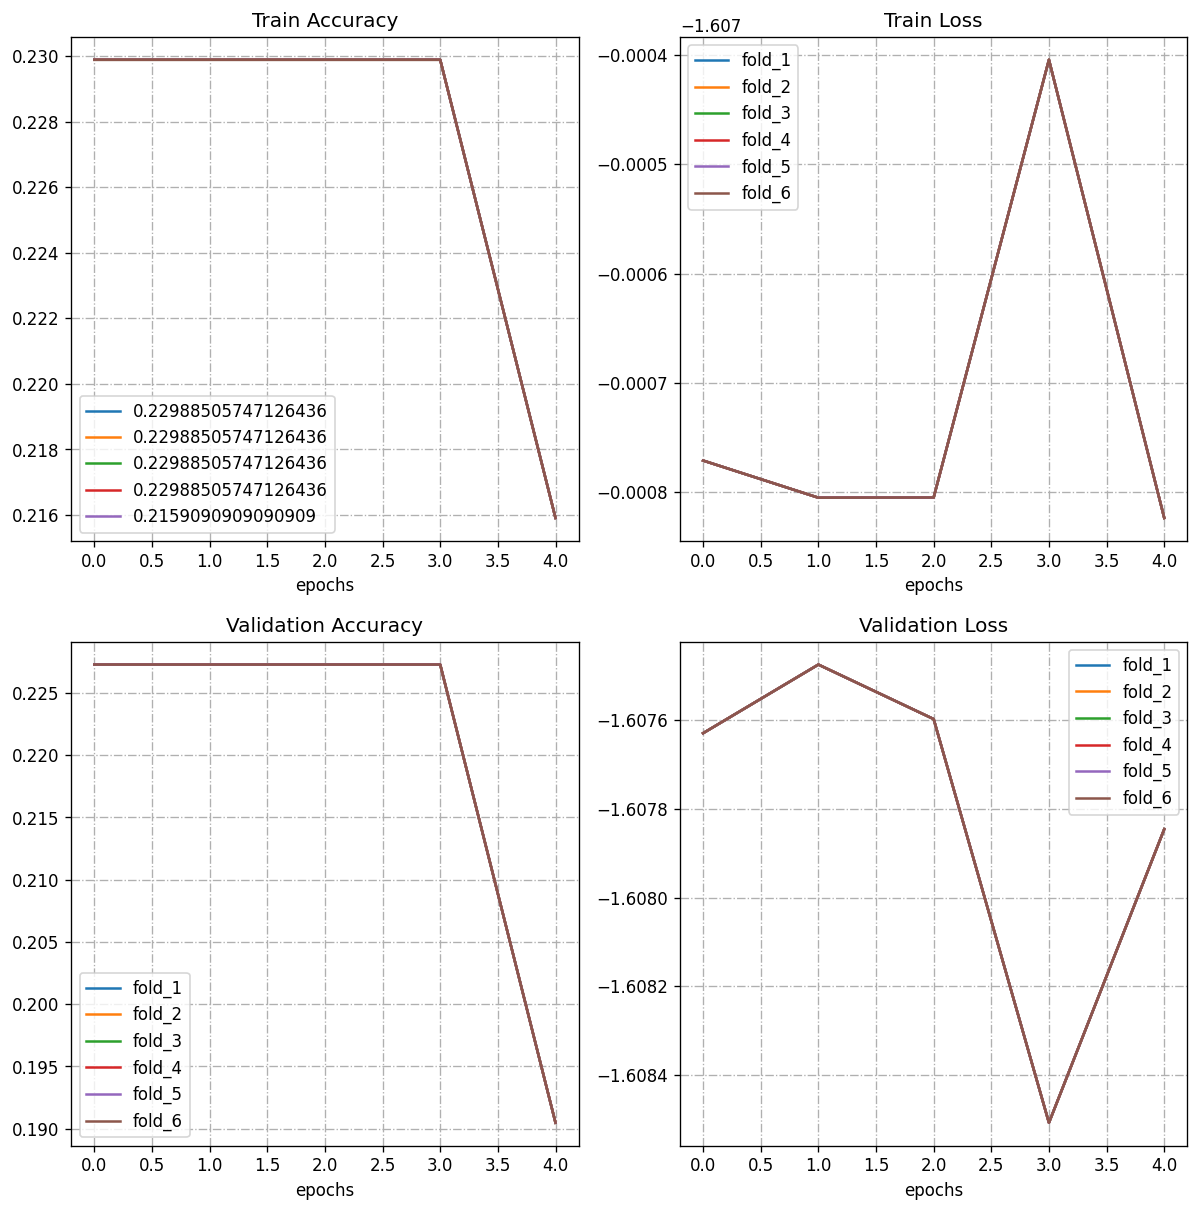

In [15]:
fig, axs = plt.subplots(2,2, figsize = (12,12) ,dpi = 120)

folds_name = []

axs[0][0].set_title('Train Accuracy')
axs[0][0].grid(linestyle = 'dashdot')
axs[0][0].set_xlabel('epochs', fontsize = 10)
for i in range(len(scores)):
    axs[0][0].plot(scores['train_accuracy'])
    folds_name.append('fold_' + str(i + 1) )
axs[0][0].legend(scores['train_accuracy'], fontsize = 10)


axs[0][1].set_title('Train Loss')
axs[0][1].grid(linestyle = 'dashdot')
axs[0][1].set_xlabel('epochs', fontsize = 10)
for i in range(len(scores)):
    axs[0][1].plot(scores['train_loss'])
axs[0][1].legend(folds_name, fontsize = 10)


axs[1][0].set_title('Validation Accuracy')
axs[1][0].grid(linestyle = 'dashdot')
axs[1][0].set_xlabel('epochs', fontsize = 10)
for i in range(len(scores)):
    axs[1][0].plot(scores['test_accuracy'])
axs[1][0].legend(folds_name, fontsize = 10)


axs[1][1].set_title('Validation Loss')
axs[1][1].grid(linestyle = 'dashdot')
axs[1][1].set_xlabel('epochs', fontsize = 10)
for i in range(len(scores)):
    axs[1][1].plot(scores['test_loss'])
axs[1][1].legend(folds_name, fontsize = 10)

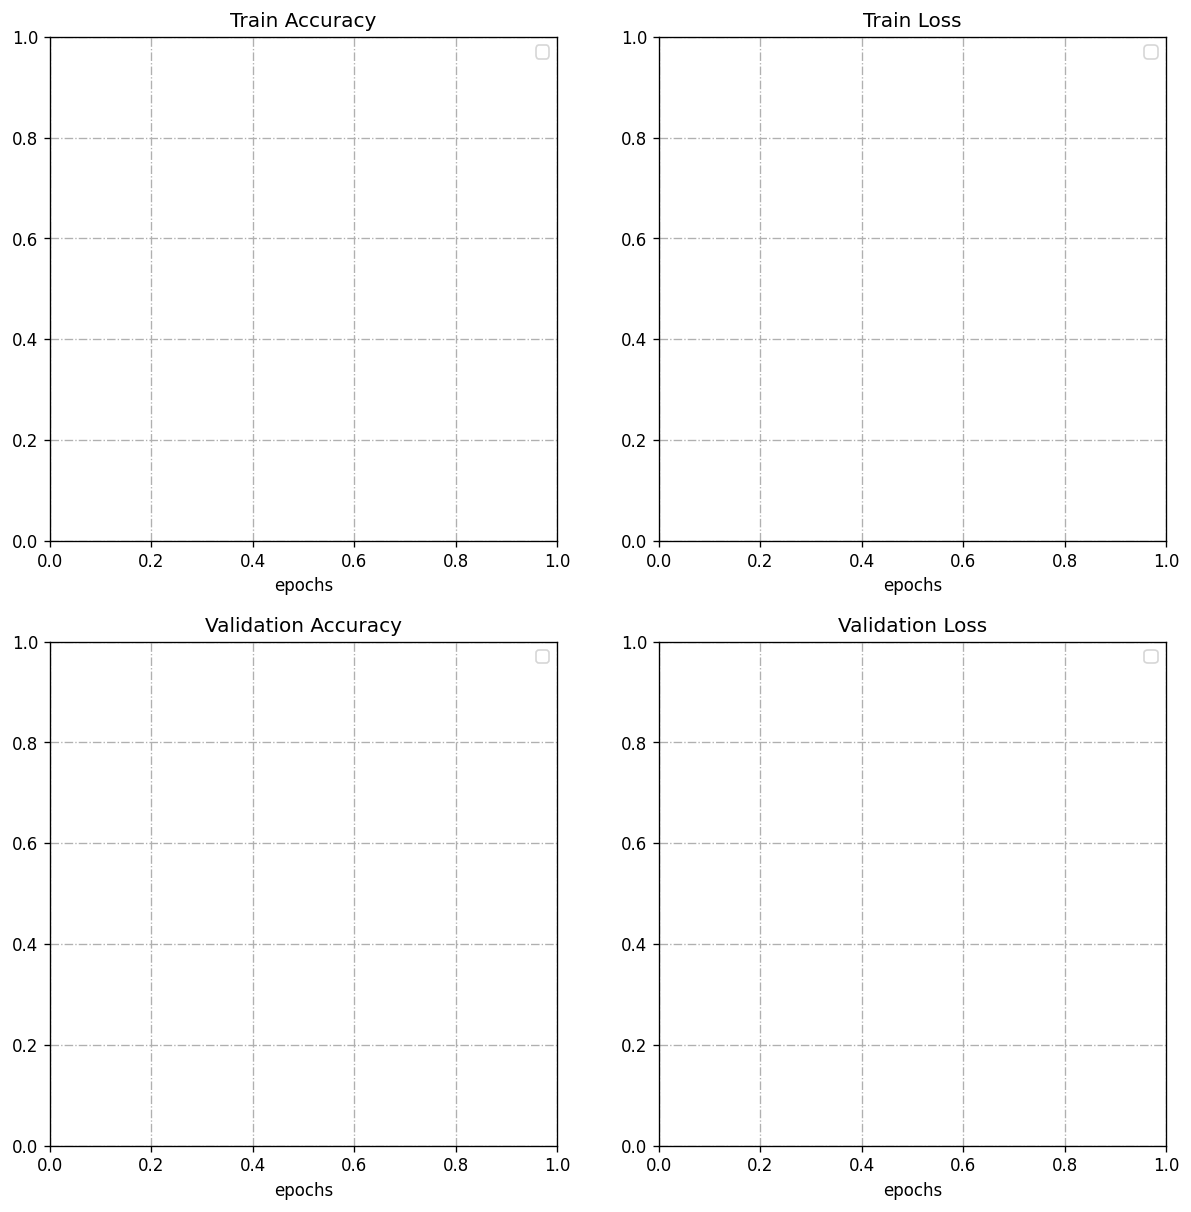

In [70]:
fig, axs = plt.subplots(2,2, figsize = (12,12) ,dpi = 120)

folds_name = []

axs[0][0].set_title('Train Accuracy')
axs[0][0].grid(linestyle = 'dashdot')
axs[0][0].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[0][0].plot(fold_hists[i].history['accuracy'])
    folds_name.append('fold_' + str(i + 1) )
axs[0][0].legend(folds_name, fontsize = 10)


axs[0][1].set_title('Train Loss')
axs[0][1].grid(linestyle = 'dashdot')
axs[0][1].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[0][1].plot(fold_hists[i].history['loss'])
axs[0][1].legend(folds_name, fontsize = 10)


axs[1][0].set_title('Validation Accuracy')
axs[1][0].grid(linestyle = 'dashdot')
axs[1][0].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[1][0].plot(fold_hists[i].history['val_accuracy'])
axs[1][0].legend(folds_name, fontsize = 10)


axs[1][1].set_title('Validation Loss')
axs[1][1].grid(linestyle = 'dashdot')
axs[1][1].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[1][1].plot(fold_hists[i].history['val_loss'])
axs[1][1].legend(folds_name, fontsize = 10)

In [177]:
from sklearn.metrics import classification_report, confusion_matrix

# Testing the model using test data
# Function predict() predicts the labels of the data values
# on the basis of the trained model
# predictions is a vector of probabilities for each digit

predictions = model.predict(data_test)
# predicted digit is one with the greatest probability

y_pred = np.argmax(predictions,axis=1)

2/2 [==============================] - 1s 512ms/step


In [101]:
y_pred = np.argmax(predictions,axis=1)

y_test = []
for images, labels in data_test:
    y_test.extend(labels.numpy())
    
# Confusion matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, y_test))

# Classification report includes precision,
# recall, f1-score, and the number of actual occurrences
print('Classification Report')

# y_test
print(classification_report(y_pred, y_test))

NameError: name 'predictions' is not defined